# Credit card consumption prediction

In [1]:
import os 
import warnings
warnings.filterwarnings('ignore')

#Packages related to data importing, manipulation, exploratory data analysis, data understanding
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import pandas_profiling
import scipy.stats as stats

#Packages related to data visualizaiton
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.backends.backend_pdf import PdfPages

#Modules related to split the data & gridsearch
from sklearn.model_selection import train_test_split, GridSearchCV

#Module related to calculation of metrics
from sklearn import metrics

#Modules related to preprocessing (Imputation of missings, standardiszation, new features creation, converting categorical to numerical)
from sklearn.impute import MissingIndicator, SimpleImputer
#from sklearn.preprocessing import Imputer, PolynomialFeatures, KBinsDiscretizer, FunctionTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer, OrdinalEncoder

#Modules related key techniques of supervised learning 
import statsmodels.formula.api as smf

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor


In [2]:
cust_demo = pd.read_excel("CustomerDemographics.xlsx")
cust_demo.head()

ID account_type gender  age  Income  Emp_Tenure_Years  Tenure_with_Bank  \
0  19427      current      M   63  MEDIUM              30.1                10   
1  16150      current      M   36  MEDIUM              14.4                10   
2  11749      current      F   28  MEDIUM               4.8                10   
3  11635      current      M   32  MEDIUM               9.6                 2   
4   8908      current      M   32    HIGH              12.0                 7   

   region_code  NetBanking_Flag  Avg_days_between_transaction  
0        628.0                1                           5.0  
1        656.0                0                          12.0  
2        314.0                1                          13.0  
3        614.0                1                          19.0  
4        750.0                1                          18.0

In [3]:
cust_demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            20000 non-null  int64  
 1   account_type                  19999 non-null  object 
 2   gender                        19999 non-null  object 
 3   age                           20000 non-null  int64  
 4   Income                        19999 non-null  object 
 5   Emp_Tenure_Years              20000 non-null  float64
 6   Tenure_with_Bank              20000 non-null  int64  
 7   region_code                   19999 non-null  float64
 8   NetBanking_Flag               20000 non-null  int64  
 9   Avg_days_between_transaction  19997 non-null  float64
dtypes: float64(3), int64(4), object(3)
memory usage: 1.5+ MB


In [4]:
cust_demo.isnull().sum()

ID                              0
account_type                    1
gender                          1
age                             0
Income                          1
Emp_Tenure_Years                0
Tenure_with_Bank                0
region_code                     1
NetBanking_Flag                 0
Avg_days_between_transaction    3
dtype: int64

In [5]:
cust_demo_cols = list(cust_demo.columns)
cust_demo_cols

['ID',
 'account_type',
 'gender',
 'age',
 'Income',
 'Emp_Tenure_Years',
 'Tenure_with_Bank',
 'region_code',
 'NetBanking_Flag',
 'Avg_days_between_transaction']

## Missing value treatment

In [6]:
def missing_treat(x):
    if x.dtype == 'object':
        if x.isna().mean()<0.2:
            x = x.fillna(x.mode()[0])  
    else:
        if x.isna().mean()<0.2:
            x = x.fillna(x.median())  
    return x

In [7]:
cust_demo = cust_demo.apply(missing_treat)

In [8]:
cust_demo.isna().sum()

ID                              0
account_type                    0
gender                          0
age                             0
Income                          0
Emp_Tenure_Years                0
Tenure_with_Bank                0
region_code                     0
NetBanking_Flag                 0
Avg_days_between_transaction    0
dtype: int64

In [9]:
cust_demo.shape

(20000, 10)

In [10]:
cust_demo.nunique()

ID                              20000
account_type                        2
gender                              2
age                                43
Income                              3
Emp_Tenure_Years                  270
Tenure_with_Bank                   10
region_code                       210
NetBanking_Flag                     2
Avg_days_between_transaction       19
dtype: int64

In [11]:
cust_behaviour = pd.read_excel("CustomerBehaviorData.xlsx")
cust_behaviour.head()

ID  cc_cons_apr  dc_cons_apr  cc_cons_may  dc_cons_may  cc_cons_jun  \
0  17051      3412.60      2909.34      1077.36      3084.50      4615.97   
1  11491     18133.76      3877.00      6123.78      5597.43     64620.00   
2   7433      6363.65       735.49      8799.00     13768.00     38266.00   
3  14606     12765.66      4429.16     16745.86      6360.00     29063.97   
4   8381     27819.70      1944.00      7006.50      2228.50      1096.25   

   dc_cons_jun  cc_count_apr  cc_count_may  cc_count_jun  ...  \
0       6693.0          19.0            10             2  ...   
1       6117.0           4.0            60             1  ...   
2       2638.0           2.0            83            47  ...   
3       3711.0          12.0             2            16  ...   
4       1065.0          15.0            13            61  ...   

   credit_count_may  debit_count_may  max_credit_amount_may  debit_amount_jun  \
0                 1              108                97916.0          45253.64   
1                 1                4                25125.0          12912.33   
2                70               11                38546.0          93567.51   
3                43                1               180315.0         176394.48   
4                 2               14                13480.0           3167.00   

   credit_amount_jun  credit_count_jun  debit_count_jun  \
0           47635.00                 2               18   
1           18369.00                 3               49   
2           26713.00                47               49   
3           35062.74                 3               37   
4           19056.00                 2               15   

   max_credit_amount_jun  loan_enq  emi_active  
0                19947.0         Y     3448.84  
1                20585.0         Y     3812.69  
2                13950.0         Y     9432.90  
3                37018.0         Y      144.61  
4                24274.0         Y     1887.89  

[5 rows x 39 columns]

In [12]:
cust_behaviour.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     20000 non-null  int64  
 1   cc_cons_apr            20000 non-null  float64
 2   dc_cons_apr            20000 non-null  float64
 3   cc_cons_may            19999 non-null  float64
 4   dc_cons_may            20000 non-null  float64
 5   cc_cons_jun            20000 non-null  float64
 6   dc_cons_jun            19999 non-null  float64
 7   cc_count_apr           19999 non-null  float64
 8   cc_count_may           20000 non-null  int64  
 9   cc_count_jun           20000 non-null  int64  
 10  dc_count_apr           20000 non-null  int64  
 11  dc_count_may           20000 non-null  int64  
 12  dc_count_jun           20000 non-null  int64  
 13  card_lim               20000 non-null  int64  
 14  personal_loan_active   20000 non-null  int64  
 15  ve

## checking missing values

In [13]:
cust_behaviour.isna().sum()

ID                       0
cc_cons_apr              0
dc_cons_apr              0
cc_cons_may              1
dc_cons_may              0
cc_cons_jun              0
dc_cons_jun              1
cc_count_apr             1
cc_count_may             0
cc_count_jun             0
dc_count_apr             0
dc_count_may             0
dc_count_jun             0
card_lim                 0
personal_loan_active     0
vehicle_loan_active      0
personal_loan_closed     1
vehicle_loan_closed      0
investment_1             0
investment_2             0
investment_3             2
investment_4             0
debit_amount_apr         0
credit_amount_apr        0
debit_count_apr          1
credit_count_apr         0
max_credit_amount_apr    0
debit_amount_may         0
credit_amount_may        0
credit_count_may         0
debit_count_may          0
max_credit_amount_may    0
debit_amount_jun         0
credit_amount_jun        0
credit_count_jun         0
debit_count_jun          0
max_credit_amount_jun    0
l

## Missing value treatment

In [14]:
cust_behaviour = cust_behaviour.apply(missing_treat)

In [15]:
cust_behaviour.isna().sum()

ID                       0
cc_cons_apr              0
dc_cons_apr              0
cc_cons_may              0
dc_cons_may              0
cc_cons_jun              0
dc_cons_jun              0
cc_count_apr             0
cc_count_may             0
cc_count_jun             0
dc_count_apr             0
dc_count_may             0
dc_count_jun             0
card_lim                 0
personal_loan_active     0
vehicle_loan_active      0
personal_loan_closed     0
vehicle_loan_closed      0
investment_1             0
investment_2             0
investment_3             0
investment_4             0
debit_amount_apr         0
credit_amount_apr        0
debit_count_apr          0
credit_count_apr         0
max_credit_amount_apr    0
debit_amount_may         0
credit_amount_may        0
credit_count_may         0
debit_count_may          0
max_credit_amount_may    0
debit_amount_jun         0
credit_amount_jun        0
credit_count_jun         0
debit_count_jun          0
max_credit_amount_jun    0
l

In [16]:
credit_consumption = pd.read_excel("CreditConsumptionData.xlsx")

In [17]:
credit_consumption.head()

ID  cc_cons
0  12554  20014.0
1  17645  10173.0
2   7604  16095.0
3   1590   7707.0
4  16556  96408.0

In [18]:
credit_consumption.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ID       20000 non-null  int64  
 1   cc_cons  15000 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 312.6 KB


In [19]:
credit_consumption.isna().sum()

ID            0
cc_cons    5000
dtype: int64

## Merging Datasets

In [20]:
df1 = pd.merge(cust_demo, cust_behaviour, how = 'inner', on = 'ID')

In [21]:
df1.head()

ID account_type gender  age  Income  Emp_Tenure_Years  Tenure_with_Bank  \
0  19427      current      M   63  MEDIUM              30.1                10   
1  16150      current      M   36  MEDIUM              14.4                10   
2  11749      current      F   28  MEDIUM               4.8                10   
3  11635      current      M   32  MEDIUM               9.6                 2   
4   8908      current      M   32    HIGH              12.0                 7   

   region_code  NetBanking_Flag  Avg_days_between_transaction  ...  \
0        628.0                1                           5.0  ...   
1        656.0                0                          12.0  ...   
2        314.0                1                          13.0  ...   
3        614.0                1                          19.0  ...   
4        750.0                1                          18.0  ...   

   credit_count_may  debit_count_may  max_credit_amount_may  debit_amount_jun  \
0                 5               14                20770.0          44884.90   
1                 4               63                78627.0          91073.84   
2                 6               82                 1260.0          96552.00   
3                 2               78                23332.0          18250.00   
4                 3              171                41672.0          83525.75   

   credit_amount_jun  credit_count_jun  debit_count_jun  \
0          369000.75                40               96   
1          243182.32                 7               12   
2           35467.00                16               42   
3           87204.35                 2               10   
4           83992.00                21               12   

   max_credit_amount_jun  loan_enq  emi_active  
0                46088.0         Y     2646.72  
1                17953.0         Y     5469.79  
2                41121.0         Y     7207.85  
3                32003.0         Y      591.34  
4                 9626.0         Y     2621.39  

[5 rows x 48 columns]

In [22]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 19999
Data columns (total 48 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            20000 non-null  int64  
 1   account_type                  20000 non-null  object 
 2   gender                        20000 non-null  object 
 3   age                           20000 non-null  int64  
 4   Income                        20000 non-null  object 
 5   Emp_Tenure_Years              20000 non-null  float64
 6   Tenure_with_Bank              20000 non-null  int64  
 7   region_code                   20000 non-null  float64
 8   NetBanking_Flag               20000 non-null  int64  
 9   Avg_days_between_transaction  20000 non-null  float64
 10  cc_cons_apr                   20000 non-null  float64
 11  dc_cons_apr                   20000 non-null  float64
 12  cc_cons_may                   20000 non-null  float64
 13  d

In [23]:
df2 = pd.merge(df1, credit_consumption, how = 'inner', on = 'ID')

In [24]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 19999
Data columns (total 49 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            20000 non-null  int64  
 1   account_type                  20000 non-null  object 
 2   gender                        20000 non-null  object 
 3   age                           20000 non-null  int64  
 4   Income                        20000 non-null  object 
 5   Emp_Tenure_Years              20000 non-null  float64
 6   Tenure_with_Bank              20000 non-null  int64  
 7   region_code                   20000 non-null  float64
 8   NetBanking_Flag               20000 non-null  int64  
 9   Avg_days_between_transaction  20000 non-null  float64
 10  cc_cons_apr                   20000 non-null  float64
 11  dc_cons_apr                   20000 non-null  float64
 12  cc_cons_may                   20000 non-null  float64
 13  d

In [25]:
seen_data = df2[df2.cc_cons.isna() == False].drop(columns = ['ID', 'loan_enq'])

In [26]:
seen_data.head()

account_type gender  age  Income  Emp_Tenure_Years  Tenure_with_Bank  \
111      current      M   35  MEDIUM              15.0                 1   
112      current      M   35    HIGH              15.0                 6   
113      current      M   55  MEDIUM              24.5                 1   
114      current      F   29  MEDIUM               4.5                 6   
115      current      M   34  MEDIUM              12.6                 4   

     region_code  NetBanking_Flag  Avg_days_between_transaction  cc_cons_apr  \
111        708.0                0                          17.0     24893.00   
112        123.0                0                          14.0     18941.62   
113        802.0                1                           3.0      5678.87   
114        867.0                1                           4.0     30489.50   
115        802.0                1                           7.0      7441.40   

     ...  credit_count_may  debit_count_may  max_credit_amount_may  \
111  ...                 2               40                24563.0   
112  ...                 2               78                23948.0   
113  ...                 2               82                10752.0   
114  ...                23               38                12607.0   
115  ...                24               50                25213.0   

     debit_amount_jun  credit_amount_jun  credit_count_jun  debit_count_jun  \
111          30051.32            12761.0                 2               65   
112          42119.05            76206.0                21               63   
113          58373.25            75283.0                 7                1   
114          69851.51            68708.0                21               83   
115          10071.00            80140.0                 8               32   

     max_credit_amount_jun  emi_active  cc_cons  
111                50836.0     1674.09  20014.0  
112                23226.0    13043.34  10173.0  
113                27036.0    25375.27  16095.0  
114                43037.0     3544.33   7707.0  
115                32044.0    12780.44  96408.0  

[5 rows x 47 columns]

In [27]:
unseen_data = df2[df2.cc_cons.isna() == True].drop(columns = 'ID')

In [28]:
unseen_data.head()

account_type gender  age  Income  Emp_Tenure_Years  Tenure_with_Bank  \
0      current      M   63  MEDIUM              30.1                10   
1      current      M   36  MEDIUM              14.4                10   
2      current      F   28  MEDIUM               4.8                10   
3      current      M   32  MEDIUM               9.6                 2   
4      current      M   32    HIGH              12.0                 7   

   region_code  NetBanking_Flag  Avg_days_between_transaction  cc_cons_apr  \
0        628.0                1                           5.0      7998.48   
1        656.0                0                          12.0     16479.64   
2        314.0                1                          13.0     29272.03   
3        614.0                1                          19.0      9662.31   
4        750.0                1                          18.0     13239.86   

   ...  debit_count_may  max_credit_amount_may  debit_amount_jun  \
0  ...               14                20770.0          44884.90   
1  ...               63                78627.0          91073.84   
2  ...               82                 1260.0          96552.00   
3  ...               78                23332.0          18250.00   
4  ...              171                41672.0          83525.75   

   credit_amount_jun  credit_count_jun  debit_count_jun  \
0          369000.75                40               96   
1          243182.32                 7               12   
2           35467.00                16               42   
3           87204.35                 2               10   
4           83992.00                21               12   

   max_credit_amount_jun  loan_enq  emi_active  cc_cons  
0                46088.0         Y     2646.72      NaN  
1                17953.0         Y     5469.79      NaN  
2                41121.0         Y     7207.85      NaN  
3                32003.0         Y      591.34      NaN  
4                 9626.0         Y     2621.39      NaN  

[5 rows x 48 columns]

In [29]:
seen_data.dtypes

account_type                     object
gender                           object
age                               int64
Income                           object
Emp_Tenure_Years                float64
Tenure_with_Bank                  int64
region_code                     float64
NetBanking_Flag                   int64
Avg_days_between_transaction    float64
cc_cons_apr                     float64
dc_cons_apr                     float64
cc_cons_may                     float64
dc_cons_may                     float64
cc_cons_jun                     float64
dc_cons_jun                     float64
cc_count_apr                    float64
cc_count_may                      int64
cc_count_jun                      int64
dc_count_apr                      int64
dc_count_may                      int64
dc_count_jun                      int64
card_lim                          int64
personal_loan_active              int64
vehicle_loan_active               int64
personal_loan_closed            float64


In [30]:
seen_data.isna().sum().sum()

0

In [31]:
## Now, splitting the data for better clarity and to perform actions

In [32]:
seen_data_continuous = seen_data.loc[:,((seen_data.dtypes=='int64')|(seen_data.dtypes=='float64')|(seen_data.dtypes=='int32')|(seen_data.dtypes=='float32'))]
seen_data_catagorical = seen_data.loc[:,( seen_data.dtypes=='object')]

In [33]:
seen_data_continuous.head()

age  Emp_Tenure_Years  Tenure_with_Bank  region_code  NetBanking_Flag  \
111   35              15.0                 1        708.0                0   
112   35              15.0                 6        123.0                0   
113   55              24.5                 1        802.0                1   
114   29               4.5                 6        867.0                1   
115   34              12.6                 4        802.0                1   

     Avg_days_between_transaction  cc_cons_apr  dc_cons_apr  cc_cons_may  \
111                          17.0     24893.00       378.00     10288.00   
112                          14.0     18941.62       966.00     20672.00   
113                           3.0      5678.87      2724.00      1964.50   
114                           4.0     30489.50      1236.00     12609.88   
115                           7.0      7441.40      6906.04      4364.00   

     dc_cons_may  ...  credit_count_may  debit_count_may  \
111     29664.00  ...                 2               40   
112       287.00  ...                 2               78   
113      3933.11  ...                 2               82   
114      9138.14  ...                23               38   
115      1939.00  ...                24               50   

     max_credit_amount_may  debit_amount_jun  credit_amount_jun  \
111                24563.0          30051.32            12761.0   
112                23948.0          42119.05            76206.0   
113                10752.0          58373.25            75283.0   
114                12607.0          69851.51            68708.0   
115                25213.0          10071.00            80140.0   

     credit_count_jun  debit_count_jun  max_credit_amount_jun  emi_active  \
111                 2               65                50836.0     1674.09   
112                21               63                23226.0    13043.34   
113                 7                1                27036.0    25375.27   
114                21               83                43037.0     3544.33   
115                 8               32                32044.0    12780.44   

     cc_cons  
111  20014.0  
112  10173.0  
113  16095.0  
114   7707.0  
115  96408.0  

[5 rows x 44 columns]

In [34]:
seen_data_catagorical.head()

account_type gender  Income
111      current      M  MEDIUM
112      current      M    HIGH
113      current      M  MEDIUM
114      current      F  MEDIUM
115      current      M  MEDIUM

In [35]:
seen_data_continuous.columns

Index(['age', 'Emp_Tenure_Years', 'Tenure_with_Bank', 'region_code',
       'NetBanking_Flag', 'Avg_days_between_transaction', 'cc_cons_apr',
       'dc_cons_apr', 'cc_cons_may', 'dc_cons_may', 'cc_cons_jun',
       'dc_cons_jun', 'cc_count_apr', 'cc_count_may', 'cc_count_jun',
       'dc_count_apr', 'dc_count_may', 'dc_count_jun', 'card_lim',
       'personal_loan_active', 'vehicle_loan_active', 'personal_loan_closed',
       'vehicle_loan_closed', 'investment_1', 'investment_2', 'investment_3',
       'investment_4', 'debit_amount_apr', 'credit_amount_apr',
       'debit_count_apr', 'credit_count_apr', 'max_credit_amount_apr',
       'debit_amount_may', 'credit_amount_may', 'credit_count_may',
       'debit_count_may', 'max_credit_amount_may', 'debit_amount_jun',
       'credit_amount_jun', 'credit_count_jun', 'debit_count_jun',
       'max_credit_amount_jun', 'emi_active', 'cc_cons'],
      dtype='object')

In [36]:
seen_data_catagorical.columns

Index(['account_type', 'gender', 'Income'], dtype='object')

In [37]:
seen_data_continuous.describe().T

count           mean           std       min  \
age                           15000.0      47.790600  3.063277e+01     25.00   
Emp_Tenure_Years              15000.0      15.184007  2.031265e+01      0.50   
Tenure_with_Bank              15000.0       5.510000  2.865783e+00      1.00   
region_code                   15000.0     598.415467  2.200623e+02    123.00   
NetBanking_Flag               15000.0       0.719533  4.492422e-01      0.00   
Avg_days_between_transaction  15000.0      11.049600  5.492196e+00      2.00   
cc_cons_apr                   15000.0   17957.391719  2.518794e+04    253.00   
dc_cons_apr                   15000.0    8171.098287  1.477303e+04     19.35   
cc_cons_may                   15000.0   16337.054662  2.706085e+04    157.00   
dc_cons_may                   15000.0    7703.605203  1.898730e+04     22.00   
cc_cons_jun                   15000.0   12129.010832  1.848878e+04     65.00   
dc_cons_jun                   15000.0    7097.395321  1.325170e+04     62.00   
cc_count_apr                  15000.0      41.487400  9.743249e+01      1.00   
cc_count_may                  15000.0      33.490200  4.954100e+01      1.00   
cc_count_jun                  15000.0      41.507000  4.734292e+01      1.00   
dc_count_apr                  15000.0      17.171000  1.935968e+01      1.00   
dc_count_may                  15000.0      13.979733  1.708720e+01      1.00   
dc_count_jun                  15000.0      30.287267  2.925249e+01      1.00   
card_lim                      15000.0  277005.147400  1.794295e+05      0.00   
personal_loan_active          15000.0       1.000000  0.000000e+00      1.00   
vehicle_loan_active           15000.0       1.000000  0.000000e+00      1.00   
personal_loan_closed          15000.0       1.000000  0.000000e+00      1.00   
vehicle_loan_closed           15000.0       1.000000  0.000000e+00      1.00   
investment_1                  15000.0  619414.041266  3.087815e+06      0.30   
investment_2                  15000.0  233364.156531  4.073237e+05      3.00   
investment_3                  15000.0   44436.868993  8.811277e+04    462.00   
investment_4                  15000.0    3523.049025  7.373355e+03 -12179.00   
debit_amount_apr              15000.0   68234.213535  1.126786e+05      4.01   
credit_amount_apr             15000.0   80797.613772  1.989060e+05     61.38   
debit_count_apr               15000.0      36.401933  3.070008e+01      0.00   
credit_count_apr              15000.0      11.291400  1.267078e+01      0.00   
max_credit_amount_apr         15000.0   54389.538175  1.950943e+05      1.00   
debit_amount_may              15000.0   65544.915782  1.016829e+05     28.20   
credit_amount_may             15000.0   83569.352222  1.776300e+05     10.61   
credit_count_may              15000.0      11.923133  1.684356e+01      0.00   
debit_count_may               15000.0      40.996867  4.053735e+01      0.00   
max_credit_amount_may         15000.0   57187.905699  2.000194e+05      0.25   
debit_amount_jun              15000.0   76159.867235  1.545112e+05      5.23   
credit_amount_jun             15000.0   78503.163457  1.482005e+05     11.88   
credit_count_jun              15000.0      19.946400  2.720017e+01      1.00   
debit_count_jun               15000.0      44.647867  3.508908e+01      0.00   
max_credit_amount_jun         15000.0   52586.542878  1.282601e+05      0.06   
emi_active                    15000.0   15760.597697  1.179152e+05      0.00   
cc_cons                       15000.0   55157.729867  9.767097e+04      0.00   

                                      25%        50%          75%          max  
age                               33.0000      40.00      53.0000       223.00  
Emp_Tenure_Years                   5.1000       9.90      18.0000       203.00  
Tenure_with_Bank                   3.0000       6.00       8.0000        10.00  
region_code                      424.0000     623.00     799.0000       974.00  
NetBanking_Flag           

In [38]:
seen_data_catagorical.describe(include = 'object')

account_type gender  Income
count         15000  15000   15000
unique            2      2       3
top         current      M  MEDIUM
freq          12727  12945    9612

## checking outliers from Boxplots

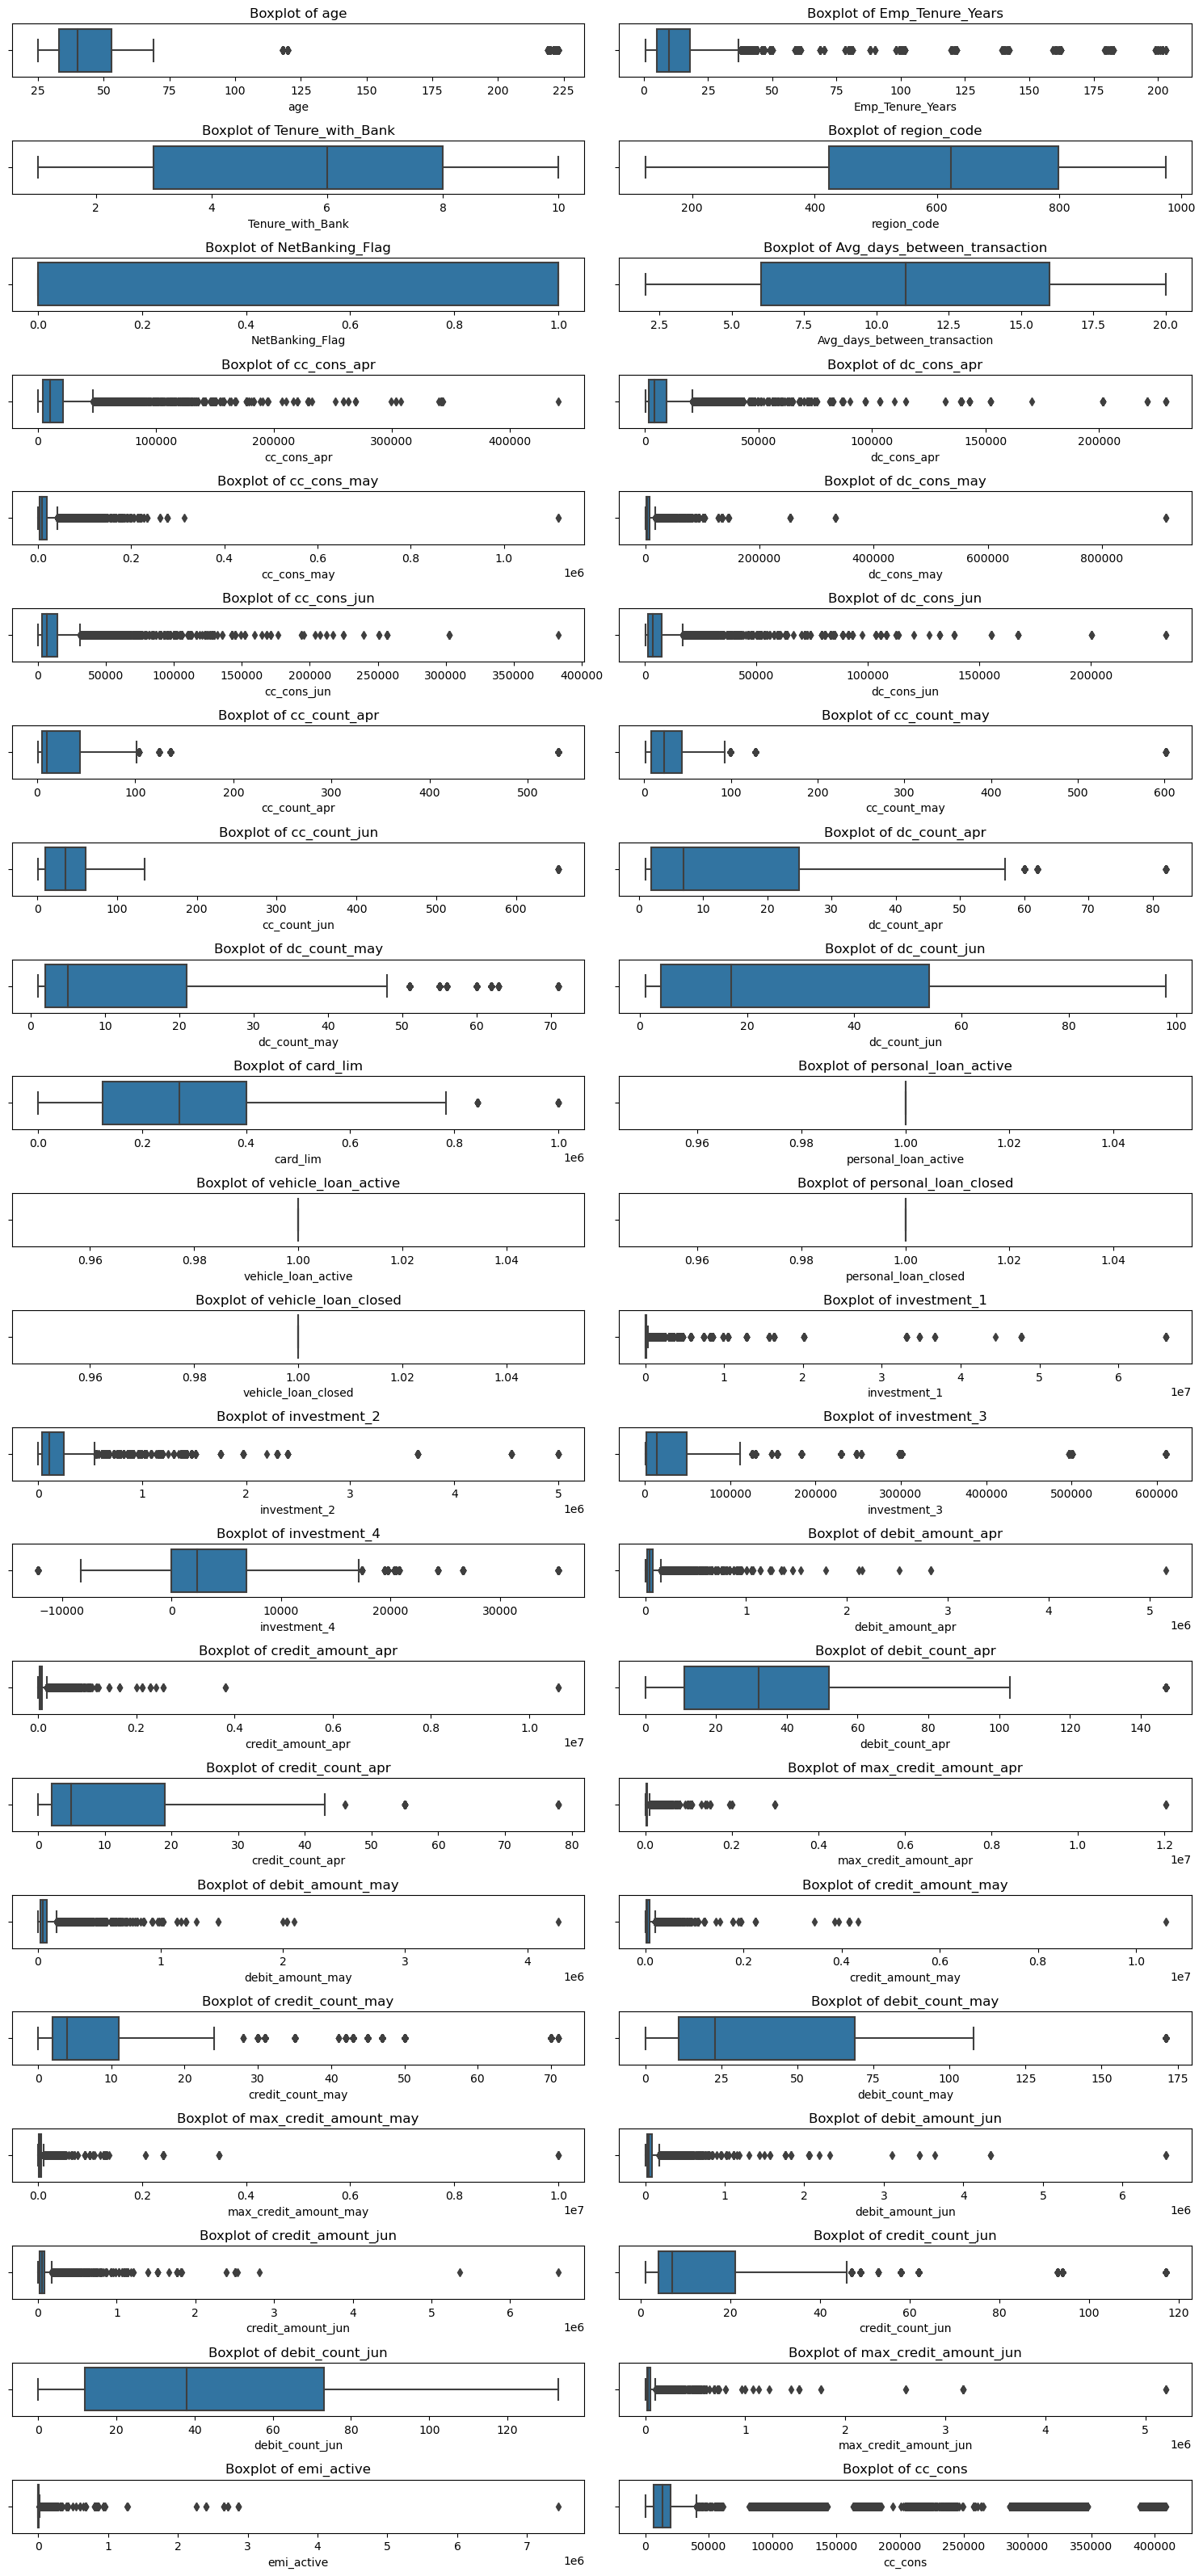

In [65]:
plt.figure(figsize=(15,32))
feature_list = seen_data_continuous.columns
for i in range(len(feature_list)):
    plt.subplot(22,2, i+1)
    sns.boxplot(x=seen_data_continuous[feature_list[i]], data=seen_data_continuous)
    plt.title(f'Boxplot of {feature_list[i]}')
    plt.tight_layout()
plt.show()

## Outlier treatment (p5p95)

In [39]:
def outlier_treat(x):
    if ((x.dtype == 'int64') | (x.dtype == 'float64')):
        x=x.clip(lower = x.quantile(0.05), upper =x.quantile(0.95))
    return x

In [40]:
for col in seen_data_continuous.columns:
    seen_data_continuous[col] = outlier_treat(seen_data_continuous[col])

In [41]:
seen_data_continuous.describe().T

count           mean            std  \
age                           15000.0      43.534533      12.623104   
Emp_Tenure_Years              15000.0      13.240307      10.657049   
Tenure_with_Bank              15000.0       5.510000       2.865783   
region_code                   15000.0     598.339400     216.225111   
NetBanking_Flag               15000.0       0.719533       0.449242   
Avg_days_between_transaction  15000.0      11.049600       5.492196   
cc_cons_apr                   15000.0   16003.995667   16000.402479   
dc_cons_apr                   15000.0    6858.220005    7395.178208   
cc_cons_may                   15000.0   14154.195644   14575.941111   
dc_cons_may                   15000.0    6273.351051    6642.550636   
cc_cons_jun                   15000.0   10579.423066   10563.246639   
dc_cons_jun                   15000.0    5809.613985    6425.399738   
cc_count_apr                  15000.0      27.149467      33.814806   
cc_count_may                  15000.0      30.375200      28.121232   
cc_count_jun                  15000.0      38.460067      29.135137   
dc_count_apr                  15000.0      16.763267      18.377073   
dc_count_may                  15000.0      13.715400      16.363076   
dc_count_jun                  15000.0      29.617733      27.864174   
card_lim                      15000.0  273319.147400  169081.913109   
personal_loan_active          15000.0       1.000000       0.000000   
vehicle_loan_active           15000.0       1.000000       0.000000   
personal_loan_closed          15000.0       1.000000       0.000000   
vehicle_loan_closed           15000.0       1.000000       0.000000   
investment_1                  15000.0  249208.015645  513409.395718   
investment_2                  15000.0  202974.961428  248284.739042   
investment_3                  15000.0   37778.725260   57495.385325   
investment_4                  15000.0    3386.948053    6639.003110   
debit_amount_apr              15000.0   58681.755152   51480.208521   
credit_amount_apr             15000.0   67223.361156   59561.239058   
debit_count_apr               15000.0      35.371333      27.725536   
credit_count_apr              15000.0      11.139067      12.260925   
max_credit_amount_apr         15000.0   43876.450063   34841.047249   
debit_amount_may              15000.0   56988.418089   52059.728178   
credit_amount_may             15000.0   71047.385788   64445.154129   
credit_count_may              15000.0      11.345733      15.000107   
debit_count_may               15000.0      38.493800      33.461380   
max_credit_amount_may         15000.0   45282.565059   38530.222898   
debit_amount_jun              15000.0   64724.853880   55773.408821   
credit_amount_jun             15000.0   66195.681528   59804.863696   
credit_count_jun              15000.0      19.395867      25.309463   
debit_count_jun               15000.0      44.192467      33.935958   
max_credit_amount_jun         15000.0   43021.388041   37505.783026   
emi_active                    15000.0    7579.904844    9404.338623   
cc_cons                       15000.0   53194.358500   91547.733635   

                                      min          25%        50%  \
age                              28.00000      33.0000      40.00   
Emp_Tenure_Years                  1.70000       5.1000       9.90   
Tenure_with_Bank                  1.00000       3.0000       6.00   
region_code                     249.00000     424.0000     623.00   
NetBanking_Flag                   0.00000       0.0000       1.00   
Avg_days_between_transaction      2.00000       6.0000      11.00   
cc_cons_apr                    1239.40000    4411.0275   10288.10   
dc_cons_apr                     376.00000    1634.0000    3996.90   
cc_cons_may                    1043.04000    3638.0000    8695.03   
dc_cons_may                     410.97000    1643.5000    3820.50   
cc_cons_jun                     833.00000    3004.5000    6655.25   
dc_cons_

In [42]:
seen_data.duplicated().sum()

0

## Dropping constatnt value features

In [43]:
seen_data_continuous.drop(columns = ['personal_loan_active', 'vehicle_loan_active', 'personal_loan_closed','vehicle_loan_closed'], inplace = True)

In [44]:
seen_data_continuous.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 111 to 15110
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   age                           15000 non-null  float64
 1   Emp_Tenure_Years              15000 non-null  float64
 2   Tenure_with_Bank              15000 non-null  int64  
 3   region_code                   15000 non-null  float64
 4   NetBanking_Flag               15000 non-null  int64  
 5   Avg_days_between_transaction  15000 non-null  float64
 6   cc_cons_apr                   15000 non-null  float64
 7   dc_cons_apr                   15000 non-null  float64
 8   cc_cons_may                   15000 non-null  float64
 9   dc_cons_may                   15000 non-null  float64
 10  cc_cons_jun                   15000 non-null  float64
 11  dc_cons_jun                   15000 non-null  float64
 12  cc_count_apr                  15000 non-null  float64
 13 

In [45]:
#coeff of variance
seen_data_continuous.apply(lambda x: x.std()/x.mean())[seen_data_continuous.apply(lambda x: x.std()/x.mean())<0.05]

Series([], dtype: float64)

## Dropping features which are irrelevant and having multi-collinearity

In [46]:
corr_matrix = seen_data_continuous.corr()
corr_matrix

age  Emp_Tenure_Years  Tenure_with_Bank  \
age                           1.000000          0.707242          0.000372   
Emp_Tenure_Years              0.707242          1.000000         -0.005777   
Tenure_with_Bank              0.000372         -0.005777          1.000000   
region_code                   0.003802         -0.000627         -0.003507   
NetBanking_Flag               0.009227          0.002154         -0.005822   
Avg_days_between_transaction  0.005484          0.006594          0.009385   
cc_cons_apr                  -0.004309         -0.002012         -0.009045   
dc_cons_apr                  -0.002101         -0.002219         -0.001636   
cc_cons_may                  -0.004655         -0.009921          0.010269   
dc_cons_may                   0.007617          0.009542          0.020881   
cc_cons_jun                  -0.009923         -0.019697         -0.012479   
dc_cons_jun                   0.005293          0.015323         -0.009901   
cc_count_apr                 -0.002639          0.007769          0.006883   
cc_count_may                  0.000447         -0.002286         -0.011014   
cc_count_jun                  0.003077         -0.001088         -0.004438   
dc_count_apr                 -0.003836          0.002066          0.002376   
dc_count_may                 -0.003472          0.005346          0.003437   
dc_count_jun                  0.011941          0.013568          0.001605   
card_lim                      0.008333          0.004397          0.006959   
investment_1                  0.002676          0.005777         -0.011001   
investment_2                 -0.002413         -0.008973         -0.006352   
investment_3                  0.009583          0.005545          0.005769   
investment_4                  0.006269         -0.001139         -0.021026   
debit_amount_apr              0.003586          0.008890         -0.017120   
credit_amount_apr             0.005279          0.006996          0.008209   
debit_count_apr              -0.002126          0.003552         -0.002108   
credit_count_apr              0.003099          0.008855          0.003319   
max_credit_amount_apr        -0.000292          0.001944         -0.003851   
debit_amount_may              0.001457          0.010108         -0.011090   
credit_amount_may             0.003999          0.005384         -0.009241   
credit_count_may              0.002398         -0.005211          0.000652   
debit_count_may               0.014191          0.010227          0.005707   
max_credit_amount_may         0.002419          0.001362          0.002347   
debit_amount_jun             -0.010724         -0.007975         -0.006841   
credit_amount_jun            -0.003427         -0.003887          0.008201   
credit_count_jun             -0.005490         -0.011542         -0.010427   
debit_count_jun               0.003474          0.007066         -0.000438   
max_credit_amount_jun        -0.003185          0.001481         -0.000193   
emi_active                    0.009245          0.006058         -0.021482   
cc_cons                      -0.004808         -0.008743          0.011196   

                              region_code  NetBanking_Flag  \
age                              0.003802         0.009227   
Emp_Tenure_Years                -0.000627         0.002154   
Tenure_with_Bank                -0.003507        -0.005822   
region_code                      1.000000         0.006785   
NetBanking_Flag                  0.006785         1.000000   
Avg_days_between_transaction    -0.016826         0.009016   
cc_cons_apr                     -0.006182         0.003644   
dc_cons_apr                     -0.006603        -0.006421   
cc_cons_may                     -0.004167         0.013655   
dc_cons_may                     -0.008242         0.004247   
cc_cons_jun                     -0.006110        -0.003079   
dc_cons_jun                      0.011781         0.003712   
cc_count_apr                  

In [47]:
## Dropping variables on basis of hign co-relation between independent variables using correlation matrix.

corr_x=seen_data_continuous.corr()
corr_x_x=corr_x.unstack().sort_values().drop_duplicates().reset_index()
corr_x_x=corr_x_x.loc[(corr_x_x[0]>0.70) | (corr_x_x[0]<-0.70)]['level_0'].drop_duplicates()
corr_x_x

779    Emp_Tenure_Years
780                 age
Name: level_0, dtype: object

In [48]:
flag = pd.DataFrame(seen_data_continuous.NetBanking_Flag)
flag.head()

NetBanking_Flag
111                0
112                0
113                1
114                1
115                1

In [49]:
seen_data_continuous.drop(columns = ['age','region_code','NetBanking_Flag'], inplace = True )

In [50]:
seen_data_continuous.head()

Emp_Tenure_Years  Tenure_with_Bank  Avg_days_between_transaction  \
111              15.0                 1                          17.0   
112              15.0                 6                          14.0   
113              24.5                 1                           3.0   
114               4.5                 6                           4.0   
115              12.6                 4                           7.0   

     cc_cons_apr  dc_cons_apr  cc_cons_may  dc_cons_may  cc_cons_jun  \
111     24893.00       378.00     10288.00     25512.15     16291.40   
112     18941.62       966.00     20672.00       410.97      4217.00   
113      5678.87      2724.00      1964.50      3933.11     23956.25   
114     30489.50      1236.00     12609.88      9138.14     17521.00   
115      7441.40      6906.04      4364.00      1939.00      2121.00   

     dc_cons_jun  cc_count_apr  ...  credit_count_may  debit_count_may  \
111     11432.00           2.0  ...               2.0             40.0   
112       885.00           1.0  ...               2.0             78.0   
113      5168.00          43.0  ...               2.0             82.0   
114     13650.30          53.0  ...              23.0             38.0   
115      6829.18          67.0  ...              24.0             50.0   

     max_credit_amount_may  debit_amount_jun  credit_amount_jun  \
111                24563.0          30051.32            12761.0   
112                23948.0          42119.05            76206.0   
113                10752.0          58373.25            75283.0   
114                12607.0          69851.51            68708.0   
115                25213.0          10071.00            80140.0   

     credit_count_jun  debit_count_jun  max_credit_amount_jun  emi_active  \
111               2.0             65.0                50836.0     1674.09   
112              21.0             63.0                23226.0    13043.34   
113               7.0              2.0                27036.0    25375.27   
114              21.0             83.0                43037.0     3544.33   
115               8.0             32.0                32044.0    12780.44   

     cc_cons  
111  20014.0  
112  10173.0  
113  16095.0  
114   7707.0  
115  96408.0  

[5 rows x 37 columns]

In [51]:
cat_encoding = pd.get_dummies(seen_data_catagorical, drop_first = True)

In [52]:
cat_encoding = pd.concat([cat_encoding, flag], axis = 1)

In [53]:
cat_encoding.head()

account_type_saving  gender_M  Income_LOW  Income_MEDIUM  NetBanking_Flag
111                    0         1           0              1                0
112                    0         1           0              0                0
113                    0         1           0              1                1
114                    0         0           0              1                1
115                    0         1           0              1                1

In [54]:
df = pd.concat([seen_data_continuous, cat_encoding], axis = 1)

In [55]:
df.head()

Emp_Tenure_Years  Tenure_with_Bank  Avg_days_between_transaction  \
111              15.0                 1                          17.0   
112              15.0                 6                          14.0   
113              24.5                 1                           3.0   
114               4.5                 6                           4.0   
115              12.6                 4                           7.0   

     cc_cons_apr  dc_cons_apr  cc_cons_may  dc_cons_may  cc_cons_jun  \
111     24893.00       378.00     10288.00     25512.15     16291.40   
112     18941.62       966.00     20672.00       410.97      4217.00   
113      5678.87      2724.00      1964.50      3933.11     23956.25   
114     30489.50      1236.00     12609.88      9138.14     17521.00   
115      7441.40      6906.04      4364.00      1939.00      2121.00   

     dc_cons_jun  cc_count_apr  ...  credit_count_jun  debit_count_jun  \
111     11432.00           2.0  ...               2.0             65.0   
112       885.00           1.0  ...              21.0             63.0   
113      5168.00          43.0  ...               7.0              2.0   
114     13650.30          53.0  ...              21.0             83.0   
115      6829.18          67.0  ...               8.0             32.0   

     max_credit_amount_jun  emi_active  cc_cons  account_type_saving  \
111                50836.0     1674.09  20014.0                    0   
112                23226.0    13043.34  10173.0                    0   
113                27036.0    25375.27  16095.0                    0   
114                43037.0     3544.33   7707.0                    0   
115                32044.0    12780.44  96408.0                    0   

     gender_M  Income_LOW  Income_MEDIUM  NetBanking_Flag  
111         1           0              1                0  
112         1           0              0                0  
113         1           0              1                1  
114         0           0              1                1  
115         1           0              1                1  

[5 rows x 42 columns]

In [56]:
y = df.cc_cons
X = df[df.columns.difference(['cc_cons'])]

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Preprocessing – Scaling the features

In [58]:
scaler = StandardScaler()

In [59]:
X_train.columns

Index(['Avg_days_between_transaction', 'Emp_Tenure_Years', 'Income_LOW',
       'Income_MEDIUM', 'NetBanking_Flag', 'Tenure_with_Bank',
       'account_type_saving', 'card_lim', 'cc_cons_apr', 'cc_cons_jun',
       'cc_cons_may', 'cc_count_apr', 'cc_count_jun', 'cc_count_may',
       'credit_amount_apr', 'credit_amount_jun', 'credit_amount_may',
       'credit_count_apr', 'credit_count_jun', 'credit_count_may',
       'dc_cons_apr', 'dc_cons_jun', 'dc_cons_may', 'dc_count_apr',
       'dc_count_jun', 'dc_count_may', 'debit_amount_apr', 'debit_amount_jun',
       'debit_amount_may', 'debit_count_apr', 'debit_count_jun',
       'debit_count_may', 'emi_active', 'gender_M', 'investment_1',
       'investment_2', 'investment_3', 'investment_4', 'max_credit_amount_apr',
       'max_credit_amount_jun', 'max_credit_amount_may'],
      dtype='object')

In [60]:
selected_features = X_train[['Avg_days_between_transaction', 'Emp_Tenure_Years', 
        'Tenure_with_Bank',
        'card_lim', 'cc_cons_apr', 'cc_cons_jun',
       'cc_cons_may', 'cc_count_apr', 'cc_count_jun', 'cc_count_may',
       'credit_amount_apr', 'credit_amount_jun', 'credit_amount_may',
       'credit_count_apr', 'credit_count_jun', 'credit_count_may',
       'dc_cons_apr', 'dc_cons_jun', 'dc_cons_may', 'dc_count_apr',
       'dc_count_jun', 'dc_count_may', 'debit_amount_apr', 'debit_amount_jun',
       'debit_amount_may', 'debit_count_apr', 'debit_count_jun',
       'debit_count_may', 'emi_active', 'investment_1',
       'investment_2', 'investment_3', 'investment_4', 'max_credit_amount_apr',
       'max_credit_amount_jun', 'max_credit_amount_may']]

In [61]:
scaled_features = scaler.fit_transform(selected_features)

In [62]:
 X_train[['Avg_days_between_transaction', 'Emp_Tenure_Years', 
        'Tenure_with_Bank',
        'card_lim', 'cc_cons_apr', 'cc_cons_jun',
       'cc_cons_may', 'cc_count_apr', 'cc_count_jun', 'cc_count_may',
       'credit_amount_apr', 'credit_amount_jun', 'credit_amount_may',
       'credit_count_apr', 'credit_count_jun', 'credit_count_may',
       'dc_cons_apr', 'dc_cons_jun', 'dc_cons_may', 'dc_count_apr',
       'dc_count_jun', 'dc_count_may', 'debit_amount_apr', 'debit_amount_jun',
       'debit_amount_may', 'debit_count_apr', 'debit_count_jun',
       'debit_count_may', 'emi_active', 'investment_1',
       'investment_2', 'investment_3', 'investment_4', 'max_credit_amount_apr',
       'max_credit_amount_jun', 'max_credit_amount_may']] = scaled_features


In [63]:
X_train.head()

Avg_days_between_transaction  Emp_Tenure_Years  Income_LOW  \
9950                       1.624316         -1.082019           0   
9791                      -1.464888         -0.005614           0   
7204                      -0.556299         -0.866738           0   
11404                      1.442598         -0.454896           0   
931                       -0.192863          0.396867           0   

       Income_MEDIUM  NetBanking_Flag  Tenure_with_Bank  account_type_saving  \
9950               1                0          0.523057                    0   
9791               1                1          1.570277                    0   
7204               1                1          1.570277                    1   
11404              1                1         -0.175089                    0   
931                1                1          1.570277                    1   

       card_lim  cc_cons_apr  cc_cons_jun  ...  debit_count_may  emi_active  \
9950   0.620936    -0.870780     0.413410  ...         1.309967   -0.511040   
9791  -1.459139    -0.516453     0.190809  ...        -0.549667   -0.474361   
7204  -1.358395    -0.454811     0.432323  ...         1.309967   -0.217313   
11404  0.425374     0.207292     0.854371  ...        -0.909596   -0.566914   
931   -1.459139    -0.503092    -0.085748  ...        -0.729631    0.032370   

       gender_M  investment_1  investment_2  investment_3  investment_4  \
9950          1     -0.407027      1.070660      0.921435     -1.458201   
9791          1     -0.161150     -0.031342      0.529074      0.310624   
7204          1     -0.418822     -0.338588     -0.585735      0.972855   
11404         1     -0.472641     -0.742770      1.609046     -1.406982   
931           1     -0.483476      0.622946     -0.645255     -0.215328   

       max_credit_amount_apr  max_credit_amount_jun  max_credit_amount_may  
9950               -0.147663              -0.113047               0.528644  
9791               -0.504130              -0.143521              -0.721740  
7204               -0.437567               0.579127              -0.403854  
11404              -0.149899              -0.778352              -0.540877  
931                -0.058596              -1.099146               2.844824  

[5 rows x 41 columns]

In [64]:
X_test.head()

Avg_days_between_transaction  Emp_Tenure_Years  Income_LOW  \
11610                           9.0               4.8           0   
6586                            7.0              40.0           0   
13278                          10.0              24.0           0   
973                            16.0              18.2           1   
6081                            9.0               5.4           1   

       Income_MEDIUM  NetBanking_Flag  Tenure_with_Bank  account_type_saving  \
11610              1                1                 7                    0   
6586               1                1                 8                    0   
13278              1                0                 8                    0   
973                0                1                 2                    0   
6081               0                1                 7                    0   

       card_lim  cc_cons_apr  cc_cons_jun  ...  debit_count_may  emi_active  \
11610  548000.0     22538.79      3199.00  ...            108.0   2670.7700   
6586    27000.0      1499.50      7328.18  ...             17.0   2335.0700   
13278  461000.0     13572.00      4382.00  ...              8.0   1202.5300   
973     44000.0     11338.55      3990.00  ...             12.0  12427.7000   
6081   575000.0      7072.00      2616.00  ...             28.0    198.9805   

       gender_M  investment_1  investment_2  investment_3  investment_4  \
11610         1     165907.57      43200.00       13873.0       12415.0   
6586          1      52209.50      50034.93        1135.0        1411.0   
13278         1       2014.80     165000.00      100000.0       -4664.0   
973           1      47299.50     128314.74       96558.0        1500.0   
6081          1        806.25     429273.40         583.0        7478.0   

       max_credit_amount_apr  max_credit_amount_jun  max_credit_amount_may  
11610               23193.00                13401.0                33873.0  
6586                45840.00               106283.0                11422.0  
13278               32741.00                28618.0                 5630.0  
973                 49803.00                25245.0                41800.0  
6081               146789.35                35872.0                79301.0  

[5 rows x 41 columns]

In [65]:
selected_features2 = X_test[['Avg_days_between_transaction', 'Emp_Tenure_Years', 
        'Tenure_with_Bank',
        'card_lim', 'cc_cons_apr', 'cc_cons_jun',
       'cc_cons_may', 'cc_count_apr', 'cc_count_jun', 'cc_count_may',
       'credit_amount_apr', 'credit_amount_jun', 'credit_amount_may',
       'credit_count_apr', 'credit_count_jun', 'credit_count_may',
       'dc_cons_apr', 'dc_cons_jun', 'dc_cons_may', 'dc_count_apr',
       'dc_count_jun', 'dc_count_may', 'debit_amount_apr', 'debit_amount_jun',
       'debit_amount_may', 'debit_count_apr', 'debit_count_jun',
       'debit_count_may', 'emi_active', 'investment_1',
       'investment_2', 'investment_3', 'investment_4', 'max_credit_amount_apr',
       'max_credit_amount_jun', 'max_credit_amount_may']]

In [66]:
scaled_features = scaler.transform(selected_features2)

In [67]:
 X_test[['Avg_days_between_transaction', 'Emp_Tenure_Years', 
        'Tenure_with_Bank',
        'card_lim', 'cc_cons_apr', 'cc_cons_jun',
       'cc_cons_may', 'cc_count_apr', 'cc_count_jun', 'cc_count_may',
       'credit_amount_apr', 'credit_amount_jun', 'credit_amount_may',
       'credit_count_apr', 'credit_count_jun', 'credit_count_may',
       'dc_cons_apr', 'dc_cons_jun', 'dc_cons_may', 'dc_count_apr',
       'dc_count_jun', 'dc_count_may', 'debit_amount_apr', 'debit_amount_jun',
       'debit_amount_may', 'debit_count_apr', 'debit_count_jun',
       'debit_count_may', 'emi_active', 'investment_1',
       'investment_2', 'investment_3', 'investment_4', 'max_credit_amount_apr',
       'max_credit_amount_jun', 'max_credit_amount_may']] = scaled_features

In [68]:
X_test.head()

Avg_days_between_transaction  Emp_Tenure_Years  Income_LOW  \
11610                     -0.374581         -0.791858           0   
6586                      -0.738017          2.502875           0   
13278                     -0.192863          1.005270           0   
973                        0.897444          0.462387           1   
6081                      -0.374581         -0.735697           1   

       Income_MEDIUM  NetBanking_Flag  Tenure_with_Bank  account_type_saving  \
11610              1                1          0.523057                    0   
6586               1                1          0.872131                    0   
13278              1                0          0.872131                    0   
973                0                1         -1.222309                    0   
6081               0                1          0.523057                    0   

       card_lim  cc_cons_apr  cc_cons_jun  ...  debit_count_may  emi_active  \
11610  1.628380     0.410443    -0.705528  ...         2.089813   -0.521438   
6586  -1.459139    -0.909960    -0.318535  ...        -0.639649   -0.557237   
13278  1.112806    -0.152303    -0.594656  ...        -0.909596   -0.678009   
973   -1.358395    -0.292472    -0.631394  ...        -0.789619    0.519025   
6081   1.788386    -0.560236    -0.760168  ...        -0.309714   -0.785026   

       gender_M  investment_1  investment_2  investment_3  investment_4  \
11610         1     -0.161974     -0.642805     -0.413758      1.363433   
6586          1     -0.383004     -0.615365     -0.635640     -0.297276   
13278         1     -0.480583     -0.153817      1.086479     -1.214108   
973           1     -0.392549     -0.301096      1.026523     -0.283845   
6081          1     -0.482932      0.907156     -0.645255      0.618347   

       max_credit_amount_apr  max_credit_amount_jun  max_credit_amount_may  
11610              -0.597927              -0.789009              -0.297341  
6586                0.051282               1.691716              -0.877337  
13278              -0.324220              -0.382588              -1.026967  
973                 0.164887              -0.472675              -0.092556  
6081                2.945142              -0.188845               0.876239  

[5 rows x 41 columns]

In [69]:
y_train.head()

9950     10360.0
9791     17461.0
7204     17829.0
11404     5925.0
931      12518.0
Name: cc_cons, dtype: float64

In [70]:
y_test.head()

11610    11583.0
6586     18147.0
13278    11246.0
973      16587.0
6081     31951.0
Name: cc_cons, dtype: float64

## Building KNN model

In [112]:
knn_model = KNeighborsRegressor(n_neighbors=5, weights='distance')

In [113]:
knn_model = knn_model.fit(X_train, y_train)

In [114]:
train_predictions = knn_model.predict(X_test)
train_predictions

array([ 27698.930543  ,  11985.55839878, 100078.96658999, ...,
       122132.62227077,  37434.07146178,  77835.16404482])

In [115]:
def rmspe(y_true, y_pred):
    # Compute the residuals
    residuals = y_true - y_pred
    
    # Divide the residuals by the actual values
    percentage_errors = residuals / y_true
    
    # Square the percentage errors
    squared_errors = percentage_errors ** 2
    
    # Compute the mean squared error
    mean_squared_error = np.mean(squared_errors)
    
    # Take the square root of the mean squared error
    root_mean_squared_error = np.sqrt(mean_squared_error)
    
    # Multiply by 100 to obtain the percentage
    rmspe = root_mean_squared_error * 100
    
    return rmspe


In [116]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [117]:
rmse_val = [] #to store rmse values for different k
for K in range(40):
    K = K+1
    knn_model = KNeighborsRegressor(n_neighbors = K)
    knn_model.fit(X_train, y_train)  #fit the model
    pred = knn_model.predict(X_test) #make prediction on test set
    error = sqrt(mean_squared_error(y_test,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 128580.35971877705
RMSE value for k=  2 is: 111694.75575145838
RMSE value for k=  3 is: 105561.63373971112
RMSE value for k=  4 is: 102399.88783036146
RMSE value for k=  5 is: 100560.24468191994
RMSE value for k=  6 is: 99601.31825973293
RMSE value for k=  7 is: 98663.43068272971
RMSE value for k=  8 is: 98018.83424068551
RMSE value for k=  9 is: 97435.91346739026
RMSE value for k=  10 is: 97169.56869805076
RMSE value for k=  11 is: 96721.95601190612
RMSE value for k=  12 is: 96405.23095099519
RMSE value for k=  13 is: 96079.36493018942
RMSE value for k=  14 is: 95756.67665708251
RMSE value for k=  15 is: 95432.86867771196
RMSE value for k=  16 is: 95093.647254565
RMSE value for k=  17 is: 95038.59011526601
RMSE value for k=  18 is: 94764.67298281695
RMSE value for k=  19 is: 94658.36450516214
RMSE value for k=  20 is: 94514.76574848792
RMSE value for k=  21 is: 94399.78283535872
RMSE value for k=  22 is: 94381.48542362553
RMSE value for k=  23 is: 94275.147899

## Hyperparameter tuning using GridSearchCV

In [118]:
param_grid = {'n_neighbors':list(range(20)), 'weights': ['distance', 'uniform']}

In [119]:
knn_grid = GridSearchCV(KNeighborsRegressor(), param_grid = param_grid, scoring = 'neg_root_mean_squared_error', cv=5, verbose=True, n_jobs=-1)

In [120]:
knn_model = knn_grid.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


In [121]:
knn_model.best_params_

{'n_neighbors': 19, 'weights': 'uniform'}

In [122]:
knn_model.best_score_

-93746.97385261543

In [123]:
knn_model = KNeighborsRegressor(n_neighbors=19, weights='uniform')

knn_model = knn_model.fit(X_train, y_train)

In [124]:
pred = knn_model.predict(X_test)

In [125]:
pred

array([54375.72105263, 83679.57105263, 81565.66842105, ...,
       87411.68421053, 39924.92368421, 37894.36842105])

In [126]:
error = rmspe(pred, y_test)

In [127]:
print("The RMSPE value is:", error, "%")

The RMSPE value is: 241.3359266553237 %


In [150]:
from sklearn.metrics import r2_score
r2 = r2_score(y_train, knn_model.predict(X_train))

print("Train R-squared (R2) value:", r2)

Train R-squared (R2) value: 0.052080955071321156


In [151]:
r2 = r2_score(y_test, knn_model.predict(X_test))

print("Test R-squared (R2) value:", r2)

Test R-squared (R2) value: -0.043809976175907206


## Prediction on unseen data

In [93]:
unseen_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 19999
Data columns (total 48 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   account_type                  5000 non-null   object 
 1   gender                        5000 non-null   object 
 2   age                           5000 non-null   int64  
 3   Income                        5000 non-null   object 
 4   Emp_Tenure_Years              5000 non-null   float64
 5   Tenure_with_Bank              5000 non-null   int64  
 6   region_code                   5000 non-null   float64
 7   NetBanking_Flag               5000 non-null   int64  
 8   Avg_days_between_transaction  5000 non-null   float64
 9   cc_cons_apr                   5000 non-null   float64
 10  dc_cons_apr                   5000 non-null   float64
 11  cc_cons_may                   5000 non-null   float64
 12  dc_cons_may                   5000 non-null   float64
 13  cc

In [94]:
unseen_categorical = unseen_data.select_dtypes('object')
unseen_categorical

account_type gender  Income loan_enq
0          current      M  MEDIUM        Y
1          current      M  MEDIUM        Y
2          current      F  MEDIUM        Y
3          current      M  MEDIUM        Y
4          current      M    HIGH        Y
...            ...    ...     ...      ...
19995      current      F  MEDIUM        Y
19996      current      M  MEDIUM        Y
19997      current      F  MEDIUM        Y
19998      current      M     LOW        Y
19999      current      F     LOW        Y

[5000 rows x 4 columns]

In [95]:
unseen_data_one_hot = pd.get_dummies(unseen_categorical, drop_first=True)
unseen_data_one_hot

account_type_saving  gender_M  Income_LOW  Income_MEDIUM
0                        0         1           0              1
1                        0         1           0              1
2                        0         0           0              1
3                        0         1           0              1
4                        0         1           0              0
...                    ...       ...         ...            ...
19995                    0         0           0              1
19996                    0         1           0              1
19997                    0         0           0              1
19998                    0         1           1              0
19999                    0         0           1              0

[5000 rows x 4 columns]

In [98]:
flag2 = pd.DataFrame(unseen_data.NetBanking_Flag)
flag2.head()

NetBanking_Flag
0                1
1                0
2                1
3                1
4                1

In [99]:
unseen_numerical = unseen_data.select_dtypes('number')
unseen_numerical

age  Emp_Tenure_Years  Tenure_with_Bank  region_code  NetBanking_Flag  \
0       63              30.1                10        628.0                1   
1       36              14.4                10        656.0                0   
2       28               4.8                10        314.0                1   
3       32               9.6                 2        614.0                1   
4       32              12.0                 7        750.0                1   
...    ...               ...               ...          ...              ...   
19995   66              32.2                 6        354.0                1   
19996   53              19.8                 5        809.0                0   
19997   66              18.4                 1        466.0                0   
19998   32               6.0                 8        619.0                0   
19999  118              78.4                 7        882.0                1   

       Avg_days_between_transaction  cc_cons_apr  dc_cons_apr  cc_cons_may  \
0                               5.0      7998.48      2289.00      9553.00   
1                              12.0     16479.64       415.00      7386.49   
2                              13.0     29272.03     40994.00      4170.53   
3                              19.0      9662.31      5306.39      5261.00   
4                              18.0     13239.86      7063.00     19193.13   
...                             ...          ...          ...          ...   
19995                           7.0      4611.00     12015.50     69121.74   
19996                          14.0      9545.00      2061.00      4269.27   
19997                          10.0      2028.93      9454.99     11019.00   
19998                          17.0     11456.23      3999.00      2650.08   
19999                          10.0     23551.00     16821.30     15746.06   

       dc_cons_may  ...  credit_count_may  debit_count_may  \
0          2879.58  ...                 5               14   
1          6763.00  ...                 4               63   
2         26717.30  ...                 6               82   
3         11934.79  ...                 2               78   
4         22304.86  ...                 3              171   
...            ...  ...               ...              ...   
19995       550.50  ...                 0                8   
19996       901.00  ...                47               11   
19997      4774.50  ...                 2              171   
19998       290.00  ...                 3               82   
19999      1310.59  ...                 5                8   

       max_credit_amount_may  debit_amount_jun  credit_amount_jun  \
0                    20770.0          44884.90          369000.75   
1                    78627.0          91073.84          243182.32   
2                     1260.0          96552.00           35467.00   
3                    23332.0          18250.00           87204.35   
4                    41672.0          83525.75           83992.00   
...                      ...               ...                ...   
19995                24438.0         153772.21           31284.00   
19996               213000.0          18098.47           93108.00   
19997                34327.0          32198.63           46800.00   
19998                51929.0          27334.14           20201.00   
19999                32431.0          23464.59           38503.00   

       credit_count_jun  debit_count_jun  max_credit_amount_jun  emi_active  \
0                    40               96                46088.0     2646.72   
1                     7               12                17953.0     5469.79   
2                    16               42                41121.0     7207.85   
3                     2               10                32003.0      591.34   
4                    21               12                 9626.0     2621.39   
...                 ...              ...                    .

In [100]:
X_unseen = unseen_numerical[unseen_numerical.columns.difference(['cc_cons'])]
X_unseen

Avg_days_between_transaction  Emp_Tenure_Years  NetBanking_Flag  \
0                               5.0              30.1                1   
1                              12.0              14.4                0   
2                              13.0               4.8                1   
3                              19.0               9.6                1   
4                              18.0              12.0                1   
...                             ...               ...              ...   
19995                           7.0              32.2                1   
19996                          14.0              19.8                0   
19997                          10.0              18.4                0   
19998                          17.0               6.0                0   
19999                          10.0              78.4                1   

       Tenure_with_Bank  age  card_lim  cc_cons_apr  cc_cons_jun  cc_cons_may  \
0                    10   63    519000      7998.48      6881.81      9553.00   
1                    10   36    402000     16479.64     12032.60      7386.49   
2                    10   28    114000     29272.03       531.43      4170.53   
3                     2   32    298000      9662.31      7996.00      5261.00   
4                     7   32    381000     13239.86      5984.75     19193.13   
...                 ...  ...       ...          ...          ...          ...   
19995                 6   66    255000      4611.00       400.00     69121.74   
19996                 5   53    518000      9545.00      7977.50      4269.27   
19997                 1   66    359000      2028.93       793.08     11019.00   
19998                 8   32    523000     11456.23     21111.50      2650.08   
19999                 7  118     49999     23551.00     17355.00     15746.06   

       cc_count_apr  ...  investment_3  investment_4  max_credit_amount_apr  \
0               8.0  ...       80000.0        6885.0               48134.00   
1              19.0  ...       28912.0         553.0               31820.00   
2              12.0  ...        1036.0        1089.0             1035431.79   
3              24.0  ...         678.0        1931.0              159847.00   
4             100.0  ...       12000.0       10455.0               57312.04   
...             ...  ...           ...           ...                    ...   
19995           5.0  ...       51520.0       13135.0               29730.00   
19996           1.0  ...       15477.0        4856.0               22103.00   
19997           6.0  ...       13873.0        2008.0               44500.00   
19998           5.0  ...        3975.0        2351.0               52612.00   
19999         531.0  ...       16114.0       -5439.0               21748.00   

       max_credit_amount_jun  max_credit_amount_may  personal_loan_active  \
0                    46088.0                20770.0                     1   
1                    17953.0                78627.0                     1   
2                    41121.0                 1260.0                     1   
3                    32003.0                23332.0                     1   
4                     9626.0                41672.0                     1   
...                      ...                    ...                   ...   
19995                42872.0                24438.0                     1   
19996                36747.0               213000.0                     1   
19997                18810.0                34327.0                     1   
19998                11443.0                51929.0                     1   
19999                47504.0                32431.0                     1   

       personal_loan_closed  region_code  vehicle_loan_active  \
0                       1.0        628.0                    1   
1                       1.0        656.0                    1   
2                       1.0        314.0                    1   
3          

In [101]:
X_unseen.drop(columns = ['age','region_code','NetBanking_Flag','personal_loan_active', 'vehicle_loan_active', 'personal_loan_closed','vehicle_loan_closed'], inplace = True)

In [102]:
X_unseen.head()

Avg_days_between_transaction  Emp_Tenure_Years  Tenure_with_Bank  card_lim  \
0                           5.0              30.1                10    519000   
1                          12.0              14.4                10    402000   
2                          13.0               4.8                10    114000   
3                          19.0               9.6                 2    298000   
4                          18.0              12.0                 7    381000   

   cc_cons_apr  cc_cons_jun  cc_cons_may  cc_count_apr  cc_count_jun  \
0      7998.48      6881.81      9553.00           8.0            13   
1     16479.64     12032.60      7386.49          19.0             7   
2     29272.03       531.43      4170.53          12.0            44   
3      9662.31      7996.00      5261.00          24.0            47   
4     13239.86      5984.75     19193.13         100.0            14   

   cc_count_may  ...  debit_count_jun  debit_count_may  emi_active  \
0            23  ...               96               14     2646.72   
1            32  ...               12               63     5469.79   
2            30  ...               42               82     7207.85   
3            85  ...               10               78      591.34   
4             9  ...               12              171     2621.39   

   investment_1  investment_2  investment_3  investment_4  \
0      13659.00      14000.00       80000.0        6885.0   
1     942327.70     172131.00       28912.0         553.0   
2      70310.60     208652.00        1036.0        1089.0   
3     101891.25     100934.00         678.0        1931.0   
4      27316.50      90829.65       12000.0       10455.0   

   max_credit_amount_apr  max_credit_amount_jun  max_credit_amount_may  
0               48134.00                46088.0                20770.0  
1               31820.00                17953.0                78627.0  
2             1035431.79                41121.0                 1260.0  
3              159847.00                32003.0                23332.0  
4               57312.04                 9626.0                41672.0  

[5 rows x 36 columns]

In [103]:
X_unseen.isna().sum().sum()

0

In [104]:
unseen_final = pd.concat([X_unseen, unseen_data_one_hot, flag2], axis = 1)

In [105]:
unseen_final.head()

Avg_days_between_transaction  Emp_Tenure_Years  Tenure_with_Bank  card_lim  \
0                           5.0              30.1                10    519000   
1                          12.0              14.4                10    402000   
2                          13.0               4.8                10    114000   
3                          19.0               9.6                 2    298000   
4                          18.0              12.0                 7    381000   

   cc_cons_apr  cc_cons_jun  cc_cons_may  cc_count_apr  cc_count_jun  \
0      7998.48      6881.81      9553.00           8.0            13   
1     16479.64     12032.60      7386.49          19.0             7   
2     29272.03       531.43      4170.53          12.0            44   
3      9662.31      7996.00      5261.00          24.0            47   
4     13239.86      5984.75     19193.13         100.0            14   

   cc_count_may  ...  investment_3  investment_4  max_credit_amount_apr  \
0            23  ...       80000.0        6885.0               48134.00   
1            32  ...       28912.0         553.0               31820.00   
2            30  ...        1036.0        1089.0             1035431.79   
3            85  ...         678.0        1931.0              159847.00   
4             9  ...       12000.0       10455.0               57312.04   

   max_credit_amount_jun  max_credit_amount_may  account_type_saving  \
0                46088.0                20770.0                    0   
1                17953.0                78627.0                    0   
2                41121.0                 1260.0                    0   
3                32003.0                23332.0                    0   
4                 9626.0                41672.0                    0   

   gender_M  Income_LOW  Income_MEDIUM  NetBanking_Flag  
0         1           0              1                1  
1         1           0              1                0  
2         0           0              1                1  
3         1           0              1                1  
4         1           0              0                1  

[5 rows x 41 columns]

## Scaling of unseen data

In [106]:
unseen_final.columns

Index(['Avg_days_between_transaction', 'Emp_Tenure_Years', 'Tenure_with_Bank',
       'card_lim', 'cc_cons_apr', 'cc_cons_jun', 'cc_cons_may', 'cc_count_apr',
       'cc_count_jun', 'cc_count_may', 'credit_amount_apr',
       'credit_amount_jun', 'credit_amount_may', 'credit_count_apr',
       'credit_count_jun', 'credit_count_may', 'dc_cons_apr', 'dc_cons_jun',
       'dc_cons_may', 'dc_count_apr', 'dc_count_jun', 'dc_count_may',
       'debit_amount_apr', 'debit_amount_jun', 'debit_amount_may',
       'debit_count_apr', 'debit_count_jun', 'debit_count_may', 'emi_active',
       'investment_1', 'investment_2', 'investment_3', 'investment_4',
       'max_credit_amount_apr', 'max_credit_amount_jun',
       'max_credit_amount_may', 'account_type_saving', 'gender_M',
       'Income_LOW', 'Income_MEDIUM', 'NetBanking_Flag'],
      dtype='object')

In [107]:
selected_features = unseen_final[['Avg_days_between_transaction', 'Emp_Tenure_Years', 
        'Tenure_with_Bank',
        'card_lim', 'cc_cons_apr', 'cc_cons_jun',
       'cc_cons_may', 'cc_count_apr', 'cc_count_jun', 'cc_count_may',
       'credit_amount_apr', 'credit_amount_jun', 'credit_amount_may',
       'credit_count_apr', 'credit_count_jun', 'credit_count_may',
       'dc_cons_apr', 'dc_cons_jun', 'dc_cons_may', 'dc_count_apr',
       'dc_count_jun', 'dc_count_may', 'debit_amount_apr', 'debit_amount_jun',
       'debit_amount_may', 'debit_count_apr', 'debit_count_jun',
       'debit_count_may', 'emi_active', 'investment_1',
       'investment_2', 'investment_3', 'investment_4', 'max_credit_amount_apr',
       'max_credit_amount_jun', 'max_credit_amount_may']]

In [108]:
scaled_features = scaler.transform(selected_features)

In [109]:
 unseen_final[['Avg_days_between_transaction', 'Emp_Tenure_Years', 
        'Tenure_with_Bank',
        'card_lim', 'cc_cons_apr', 'cc_cons_jun',
       'cc_cons_may', 'cc_count_apr', 'cc_count_jun', 'cc_count_may',
       'credit_amount_apr', 'credit_amount_jun', 'credit_amount_may',
       'credit_count_apr', 'credit_count_jun', 'credit_count_may',
       'dc_cons_apr', 'dc_cons_jun', 'dc_cons_may', 'dc_count_apr',
       'dc_count_jun', 'dc_count_may', 'debit_amount_apr', 'debit_amount_jun',
       'debit_amount_may', 'debit_count_apr', 'debit_count_jun',
       'debit_count_may', 'emi_active', 'investment_1',
       'investment_2', 'investment_3', 'investment_4', 'max_credit_amount_apr',
       'max_credit_amount_jun', 'max_credit_amount_may']] = scaled_features


In [110]:
unseen_final.head()

Avg_days_between_transaction  Emp_Tenure_Years  Tenure_with_Bank  card_lim  \
0                     -1.101453          1.576232          1.570277  1.456522   
1                      0.170573          0.106706          1.570277  0.763164   
2                      0.352290         -0.791858          1.570277 -0.943565   
3                      1.442598         -0.342576         -1.222309  0.146845   
4                      1.260880         -0.117935          0.523057  0.638715   

   cc_cons_apr  cc_cons_jun  cc_cons_may  cc_count_apr  cc_count_jun  \
0    -0.502091    -0.360370    -0.316958     -0.572390     -0.872883   
1     0.030177     0.122369    -0.465690     -0.248147     -1.078705   
2     0.833014    -0.955537    -0.686466     -0.454483      0.190535   
3    -0.397671    -0.255946    -0.611605     -0.100763      0.293446   
4    -0.173148    -0.444444     0.344840      2.139462     -0.838579   

   cc_count_may  ...  investment_3  investment_4  max_credit_amount_apr  \
0     -0.261280  ...      0.738101      0.528853               0.117043   
1      0.058803  ...     -0.151795     -0.426765              -0.350622   
2     -0.012326  ...     -0.637364     -0.345872              28.419370   
3      1.943736  ...     -0.643600     -0.218799               3.319459   
4     -0.759186  ...     -0.446384      1.067632               0.380145   

   max_credit_amount_jun  max_credit_amount_may  account_type_saving  \
0               0.084007              -0.635842                    0   
1              -0.667432               0.858827                    0   
2              -0.048653              -1.139861                    0   
3              -0.292180              -0.569656                    0   
4              -0.889833              -0.095863                    0   

   gender_M  Income_LOW  Income_MEDIUM  NetBanking_Flag  
0         1           0              1                1  
1         1           0              1                0  
2         0           0              1                1  
3         1           0              1                1  
4         1           0              0                1  

[5 rows x 41 columns]

In [111]:
unseen_final.isna().sum().sum()

0

In [128]:
unseen_prediction = knn_model.predict(unseen_final)

In [130]:
print(unseen_prediction)

[14957.89473684 56665.39736842 24136.3        ... 49701.84210526
 77316.84210526 50481.87894737]


## Recursive feature elimination (RFE)

In [131]:
## RFE

from sklearn.feature_selection import RFE

from sklearn.ensemble import RandomForestRegressor

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

In [132]:
RFE_model = RFE(RandomForestRegressor(), n_features_to_select=30, verbose=True)

In [133]:
RFE_model = RFE_model.fit(X_train, y_train)

Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.


In [134]:
RFE_model.support_

array([ True,  True, False, False, False, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False,  True,  True,  True, False,  True, False,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True])

In [135]:
X_train.columns[RFE_model.support_]

Index(['Avg_days_between_transaction', 'Emp_Tenure_Years', 'card_lim',
       'cc_cons_apr', 'cc_cons_jun', 'cc_cons_may', 'cc_count_apr',
       'cc_count_jun', 'cc_count_may', 'credit_amount_apr',
       'credit_amount_jun', 'credit_amount_may', 'dc_cons_apr', 'dc_cons_jun',
       'dc_cons_may', 'dc_count_jun', 'debit_amount_apr', 'debit_amount_jun',
       'debit_amount_may', 'debit_count_apr', 'debit_count_jun',
       'debit_count_may', 'emi_active', 'investment_1', 'investment_2',
       'investment_3', 'investment_4', 'max_credit_amount_apr',
       'max_credit_amount_jun', 'max_credit_amount_may'],
      dtype='object')

In [136]:
X_train_new = X_train[['Avg_days_between_transaction', 'Emp_Tenure_Years', 'card_lim',
       'cc_cons_apr', 'cc_cons_jun', 'cc_cons_may', 'cc_count_apr',
       'cc_count_jun', 'cc_count_may', 'credit_amount_apr',
       'credit_amount_jun', 'credit_amount_may', 'dc_cons_apr', 'dc_cons_jun',
       'dc_cons_may', 'dc_count_jun', 'debit_amount_apr', 'debit_amount_jun',
       'debit_amount_may', 'debit_count_apr', 'debit_count_jun',
       'debit_count_may', 'emi_active', 'investment_1', 'investment_2',
       'investment_3', 'investment_4', 'max_credit_amount_apr',
       'max_credit_amount_jun', 'max_credit_amount_may']]

In [138]:
X_test_new = X_test[['Avg_days_between_transaction', 'Emp_Tenure_Years', 'card_lim',
       'cc_cons_apr', 'cc_cons_jun', 'cc_cons_may', 'cc_count_apr',
       'cc_count_jun', 'cc_count_may', 'credit_amount_apr',
       'credit_amount_jun', 'credit_amount_may', 'dc_cons_apr', 'dc_cons_jun',
       'dc_cons_may', 'dc_count_jun', 'debit_amount_apr', 'debit_amount_jun',
       'debit_amount_may', 'debit_count_apr', 'debit_count_jun',
       'debit_count_may', 'emi_active', 'investment_1', 'investment_2',
       'investment_3', 'investment_4', 'max_credit_amount_apr',
       'max_credit_amount_jun', 'max_credit_amount_may']]

In [139]:
unseen_final_new = unseen_final[['Avg_days_between_transaction', 'Emp_Tenure_Years', 'card_lim',
       'cc_cons_apr', 'cc_cons_jun', 'cc_cons_may', 'cc_count_apr',
       'cc_count_jun', 'cc_count_may', 'credit_amount_apr',
       'credit_amount_jun', 'credit_amount_may', 'dc_cons_apr', 'dc_cons_jun',
       'dc_cons_may', 'dc_count_jun', 'debit_amount_apr', 'debit_amount_jun',
       'debit_amount_may', 'debit_count_apr', 'debit_count_jun',
       'debit_count_may', 'emi_active', 'investment_1', 'investment_2',
       'investment_3', 'investment_4', 'max_credit_amount_apr',
       'max_credit_amount_jun', 'max_credit_amount_may']]

## Now build model using new features

In [140]:
knn_model_new = KNeighborsRegressor(n_neighbors=19, weights='uniform')

knn_model_new = knn_model_new.fit(X_train_new, y_train)

In [142]:
pred = knn_model_new.predict(X_test_new)

In [143]:
pred

array([52201.72105263, 85868.21052632, 55797.09736842, ...,
       35917.05263158, 41761.46578947, 45048.19473684])

In [144]:
error = rmspe(pred, y_test)

In [145]:
print("The RMSPE value is:", error, "%")

The RMSPE value is: 254.01955197051586 %


In [155]:
from sklearn.metrics import r2_score
r2 = r2_score(y_train, knn_model_new.predict(X_train_new))

print("Train R-squared (R2) value:", r2)

Train R-squared (R2) value: 0.05331398751901606


In [153]:
r2 = r2_score(y_test, knn_model_new.predict(X_test_new))

print("Test R-squared (R2) value:", r2)

Test R-squared (R2) value: -0.04119643734870104


## Prediction on unseen data with RFE

In [147]:
unseen_prediction_new = knn_model_new.predict(unseen_final_new)

In [148]:
unseen_prediction_new

array([38296.05263158, 98567.94736842, 78062.73684211, ...,
       12473.25526316, 57937.89473684, 64051.93947368])

## Support Vector Regressor

In [156]:
from sklearn.svm import LinearSVR, SVR

In [157]:
regressor = SVR(kernel='rbf')

In [159]:
svr_reg = regressor.fit(X_train_new, y_train)

In [160]:
prediction = svr_reg.predict(X_test_new)

In [161]:
error = rmspe(prediction, y_test)

In [162]:
print("The RMSPE value is:", error, "%")

The RMSPE value is: 752.695048645422 %


In [163]:
from sklearn.metrics import r2_score
r2 = r2_score(y_train, svr_reg.predict(X_train_new))

print("Train R-squared (R2) value:", r2)

Train R-squared (R2) value: -0.1897735994843479


In [164]:
r2 = r2_score(y_test, svr_reg.predict(X_test_new))

print("Test R-squared (R2) value:", r2)

Test R-squared (R2) value: -0.18563596835953544


In [151]:
#from sklearn.model_selection import GridSearchCV
#param_grid = {'C': [1, 5, 10, 50],
#              'kernel': ['rbf', 'poly', 'linear'],
#             'degree' :[1,2,3] }


In [152]:
#GCV = GridSearchCV(SVR(), param_grid = param_grid, scoring = 'neg_root_mean_squared_error', cv=5, verbose=True, n_jobs=-1)

In [165]:
#SVR_GCV = GCV.fit(X_train, y_train)

In [166]:
#print(SVR_GCV.best_params_)

In [ ]:
regressor = grid.best_estimator_
yfit = regressor.predict(test_X)

In [157]:
print(metrics.mean_absolute_percentage_error(y_train, regressor.predict(X_train)))

5028713145186541.0


In [158]:
print(metrics.mean_absolute_percentage_error(y_test, regressor.predict(X_test)))

4.194081599060869


In [159]:
from sklearn.metrics import r2_score
r2 = r2_score(y_train, regressor.predict(X_train))

print("R-squared (R2) value:", r2)

R-squared (R2) value: -0.18374196084825734


In [160]:
r2 = r2_score(y_test, regressor.predict(X_test))

print("R-squared (R2) value:", r2)

R-squared (R2) value: -0.17922242134167354


## Checking skewness of each independent variable

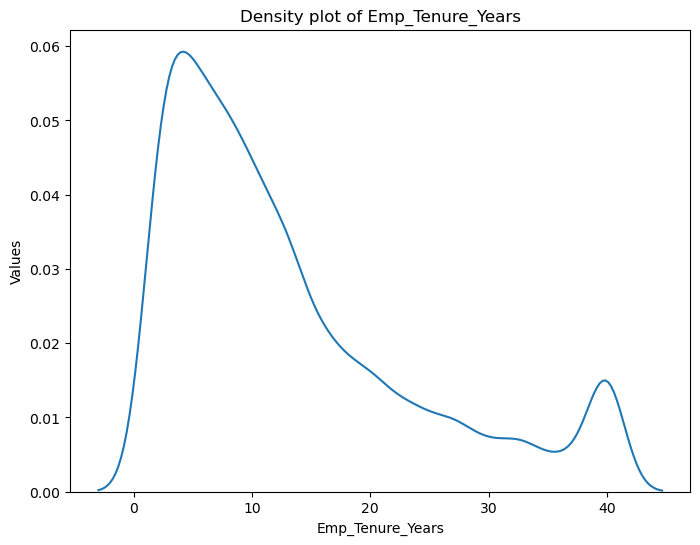

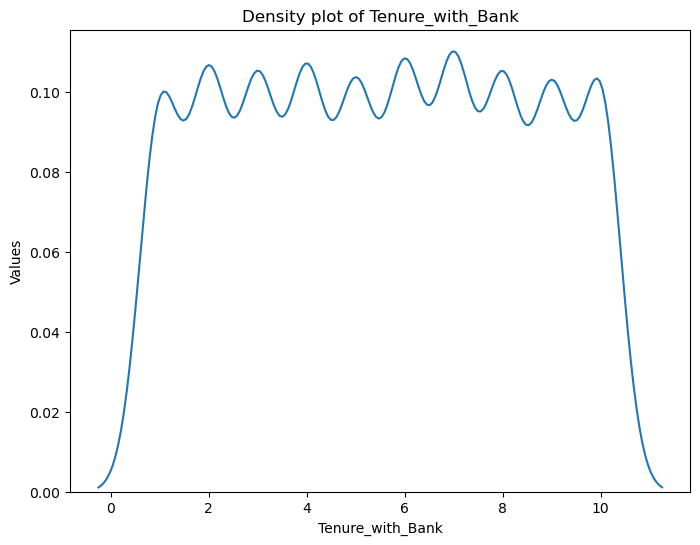

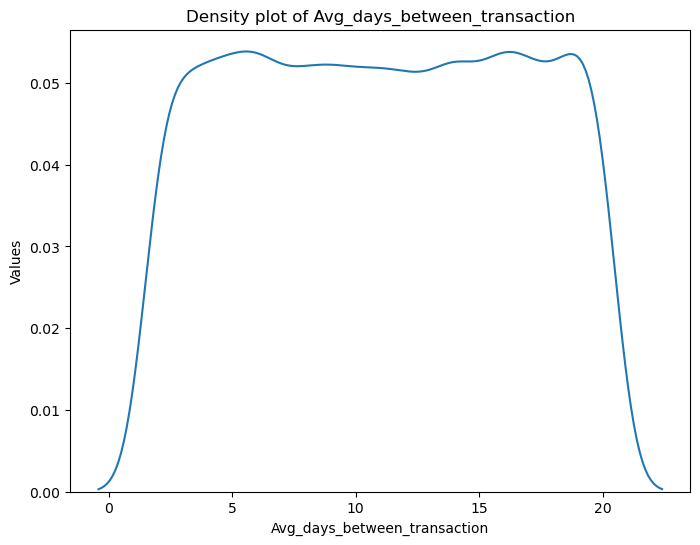

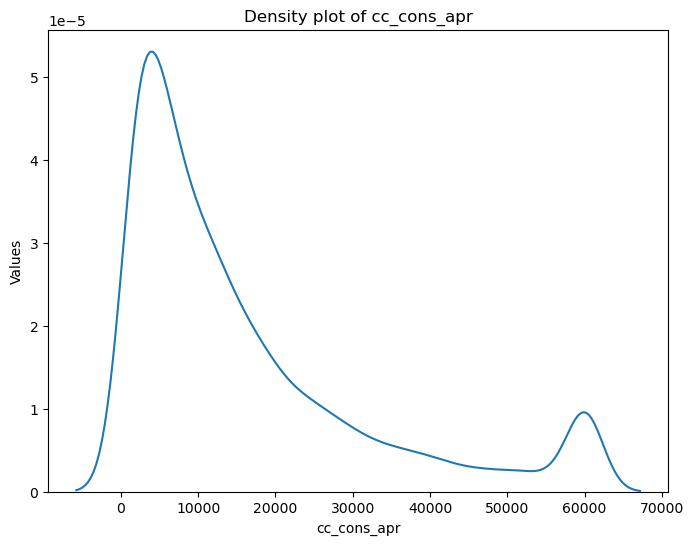

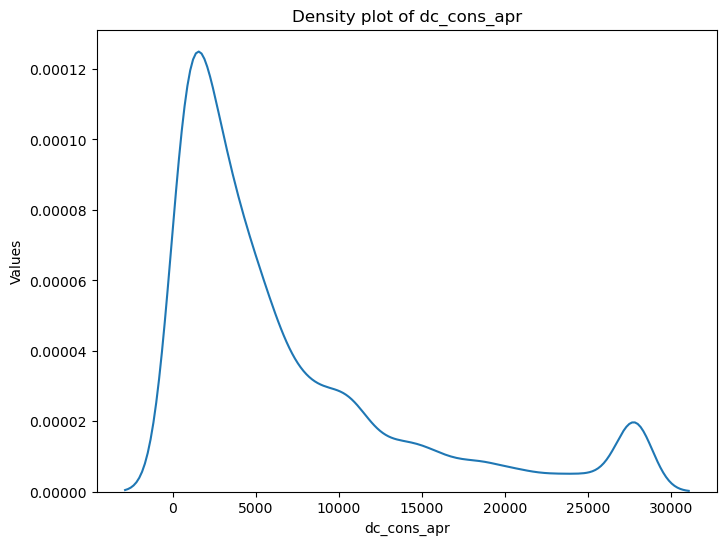

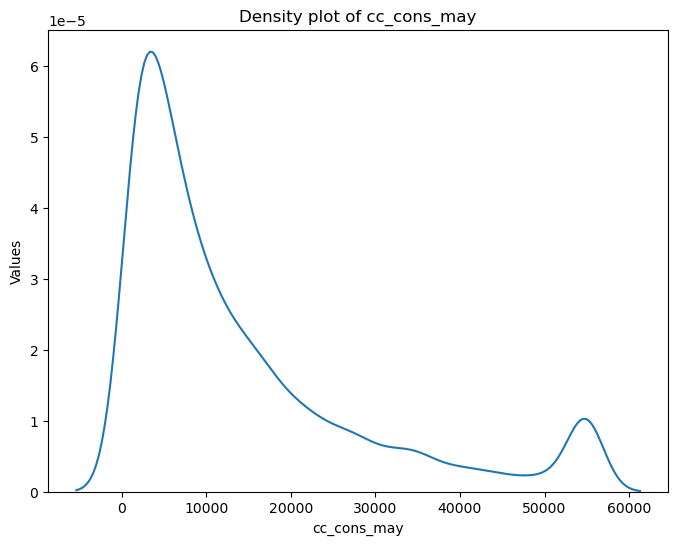

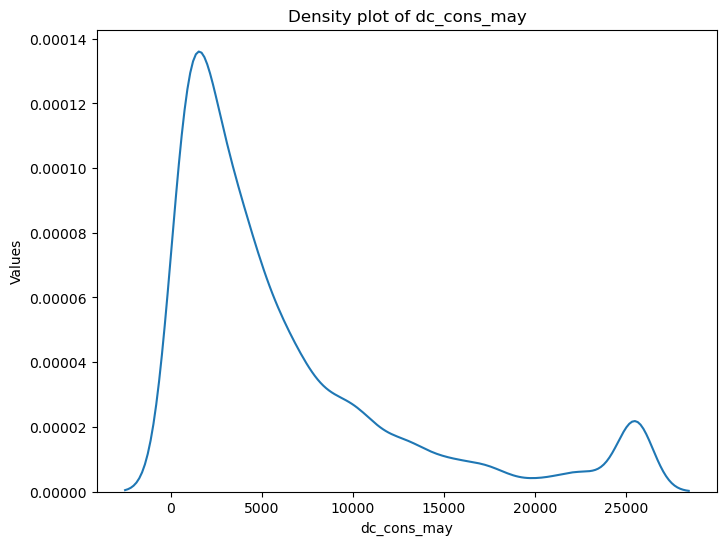

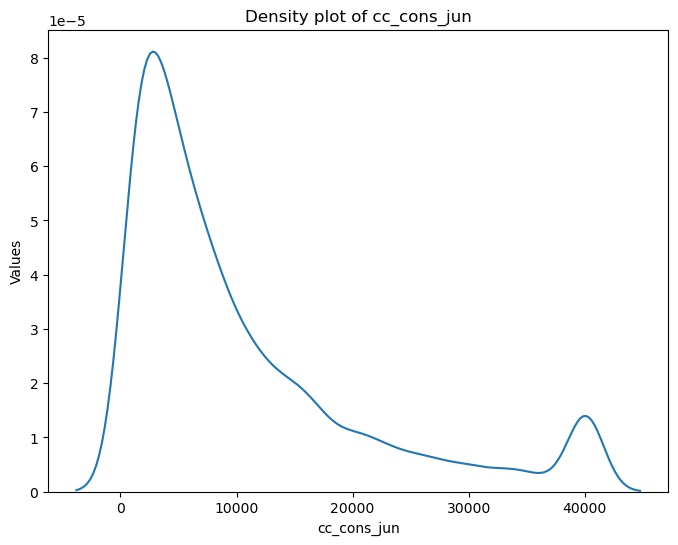

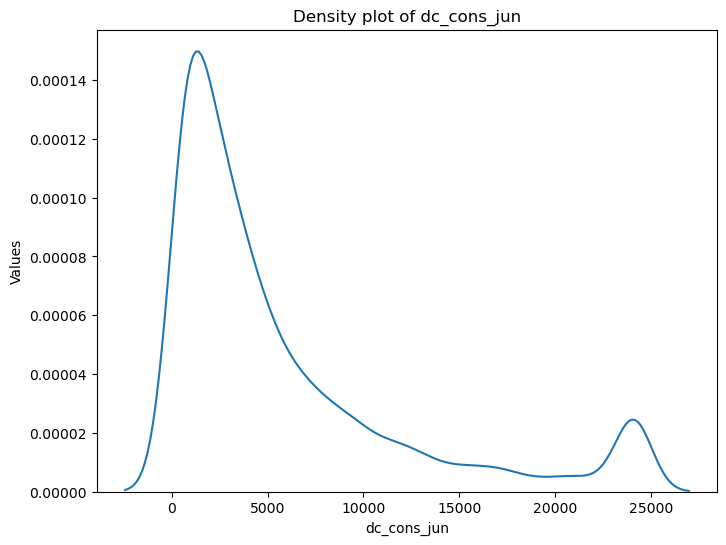

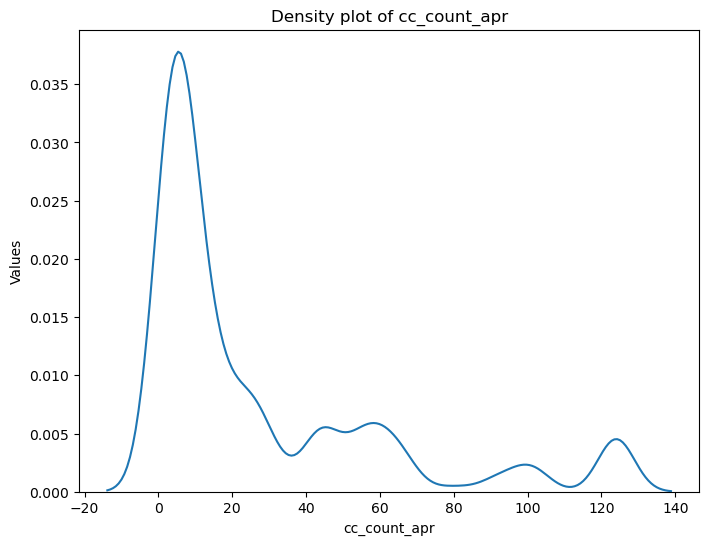

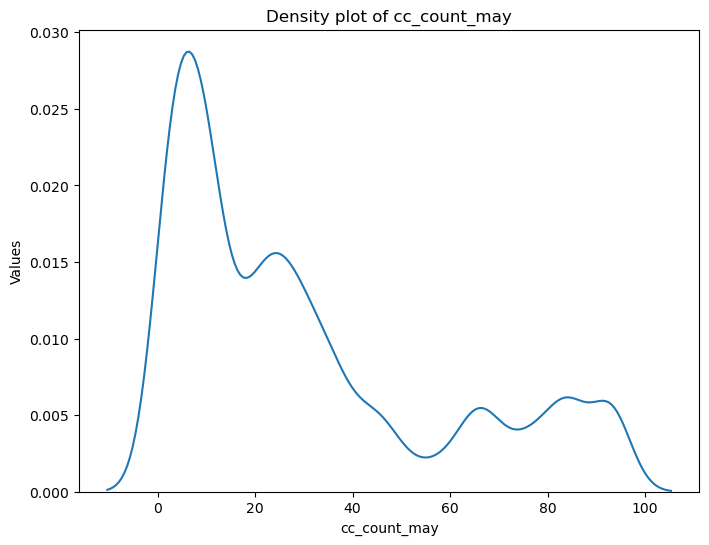

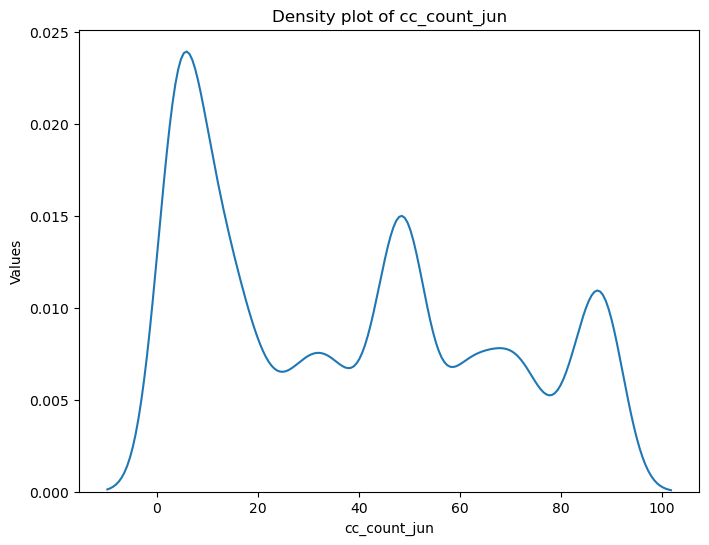

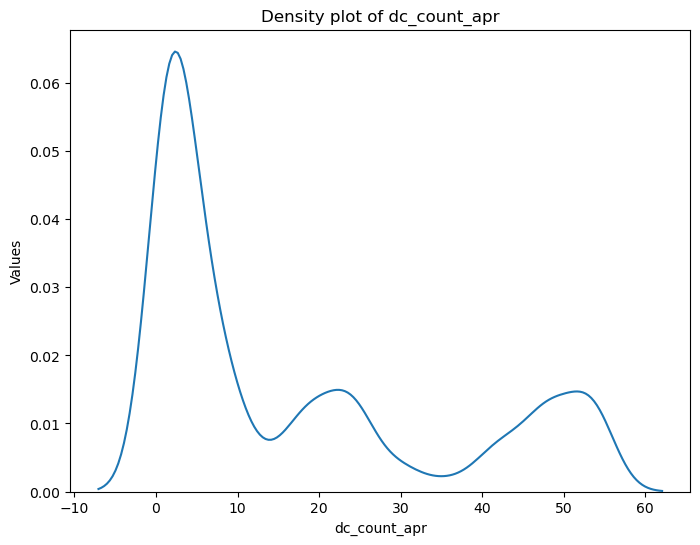

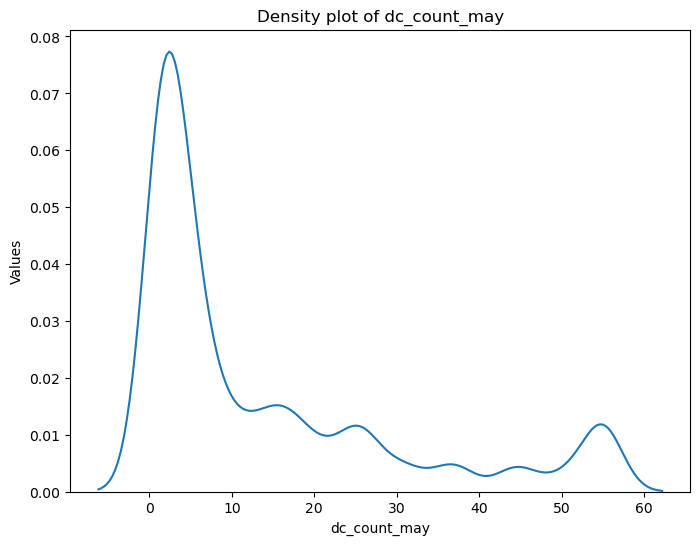

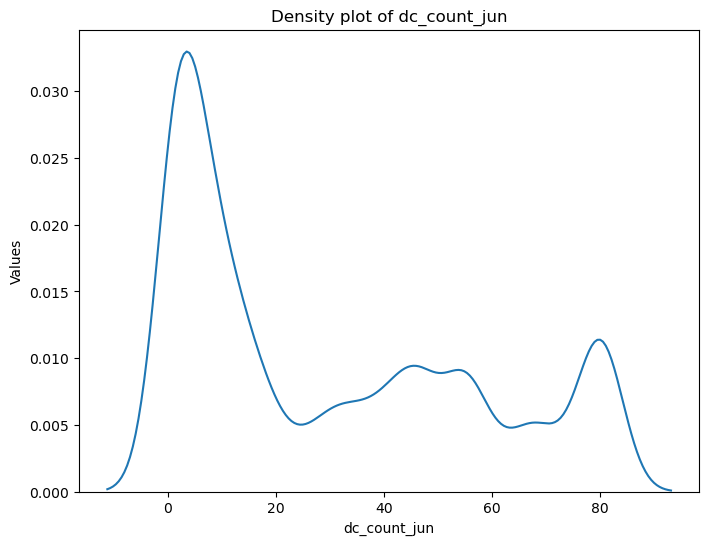

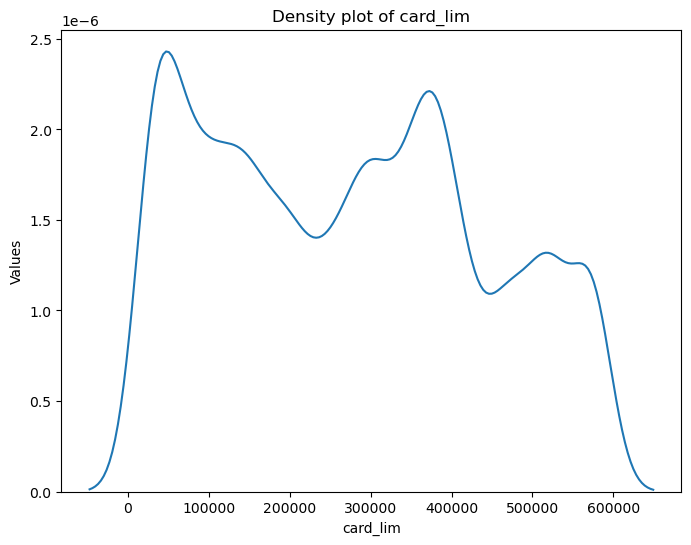

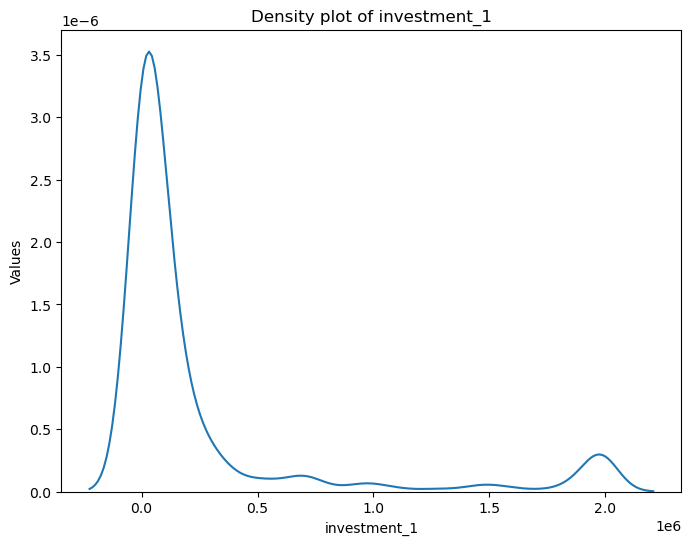

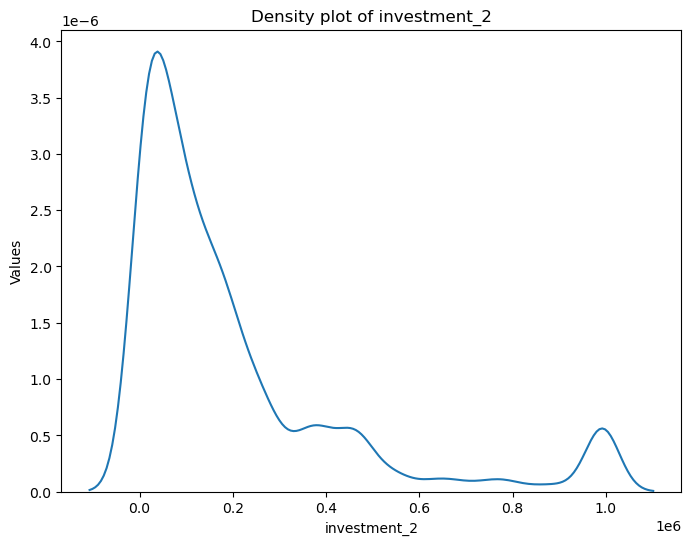

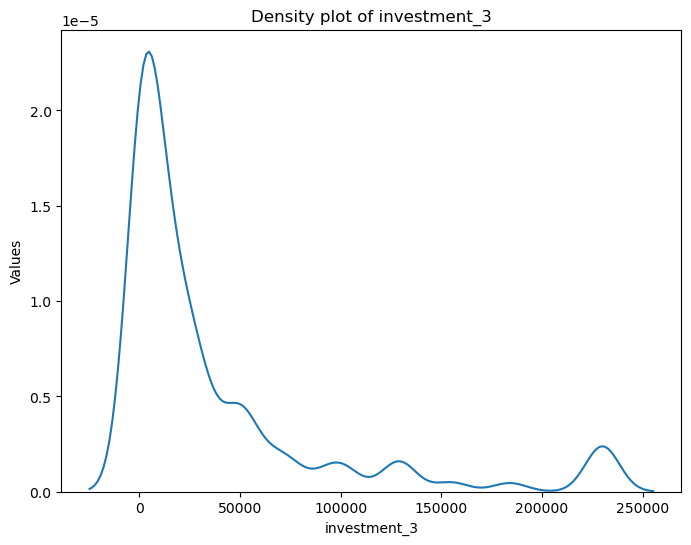

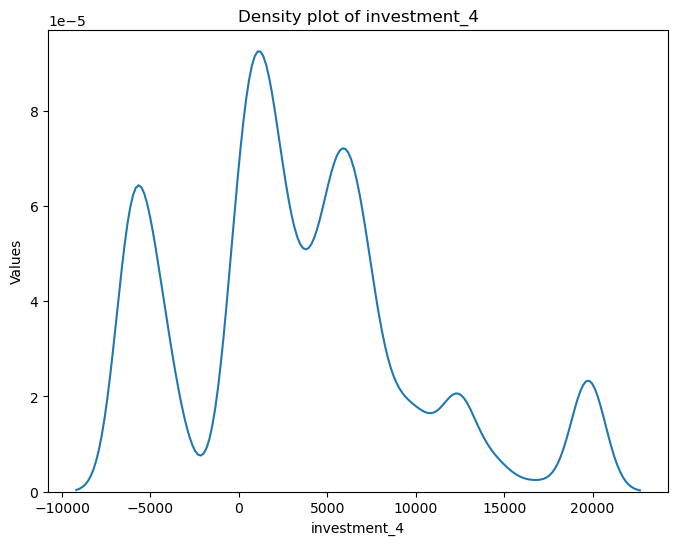

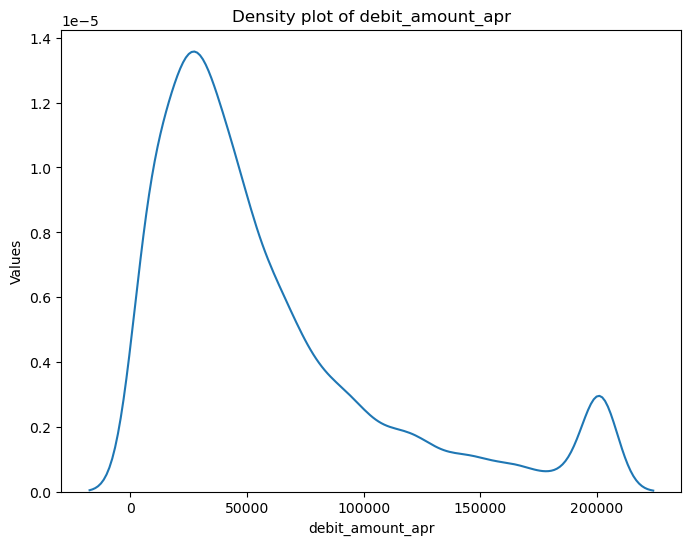

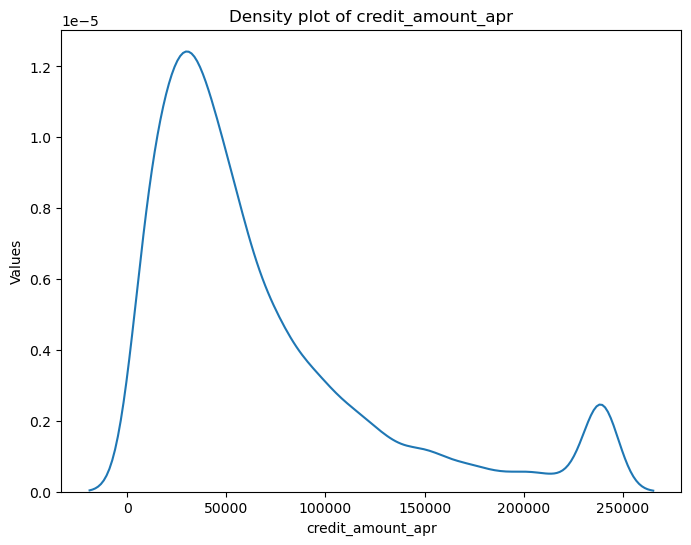

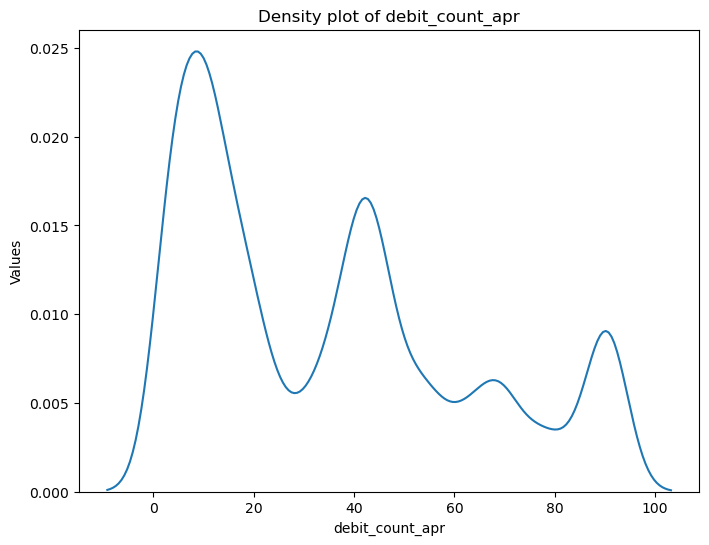

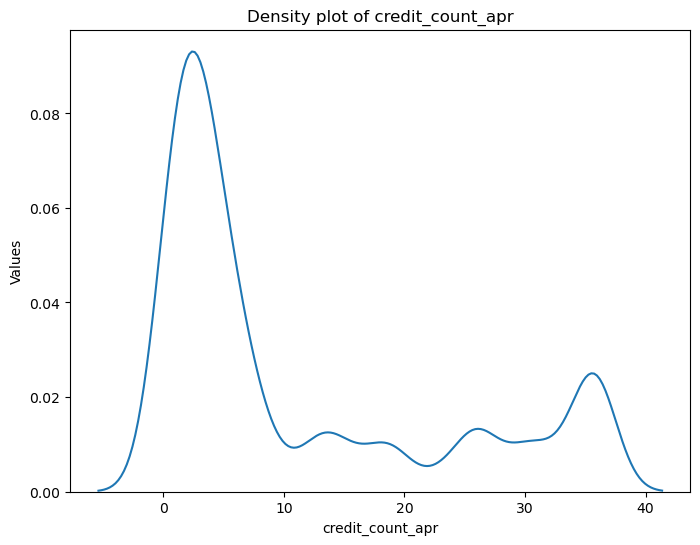

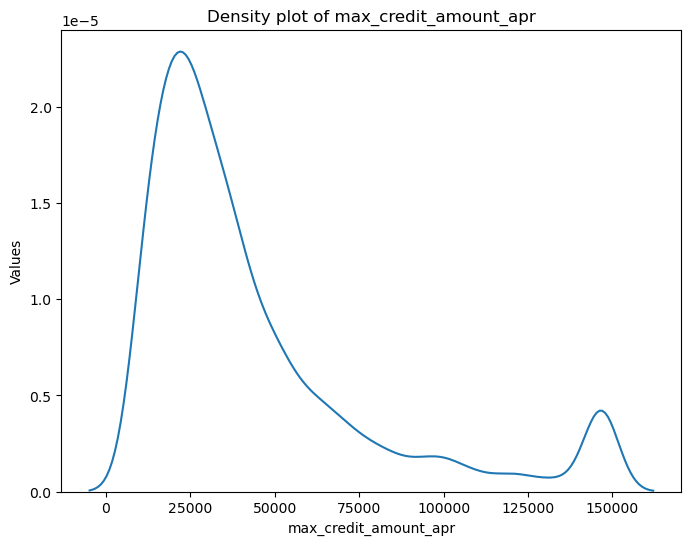

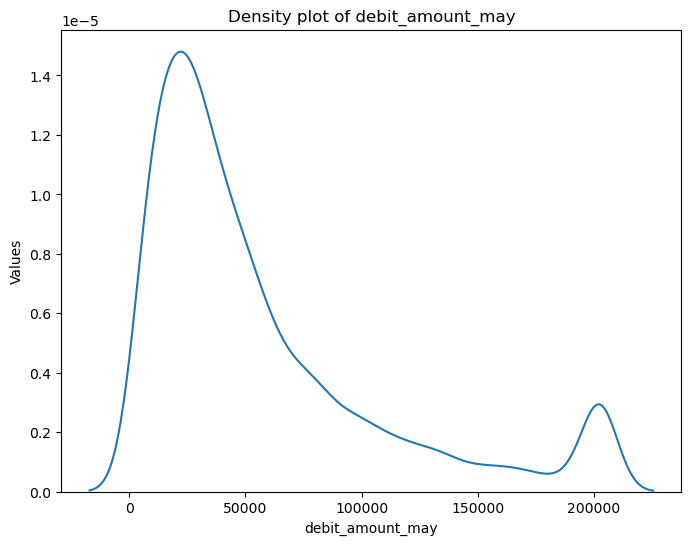

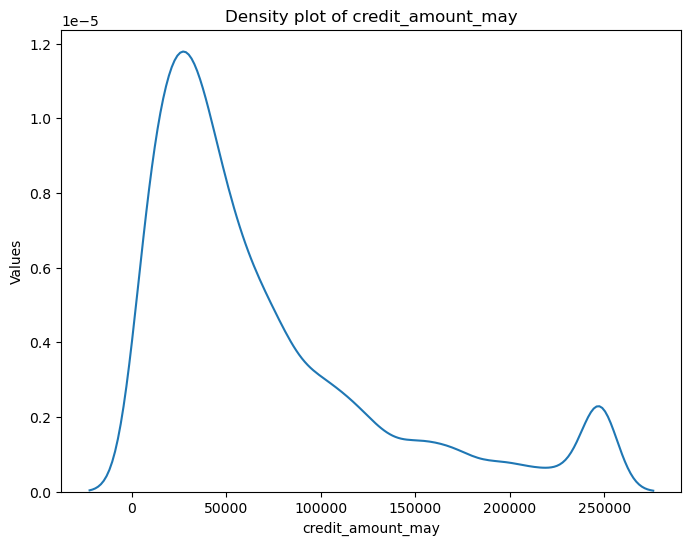

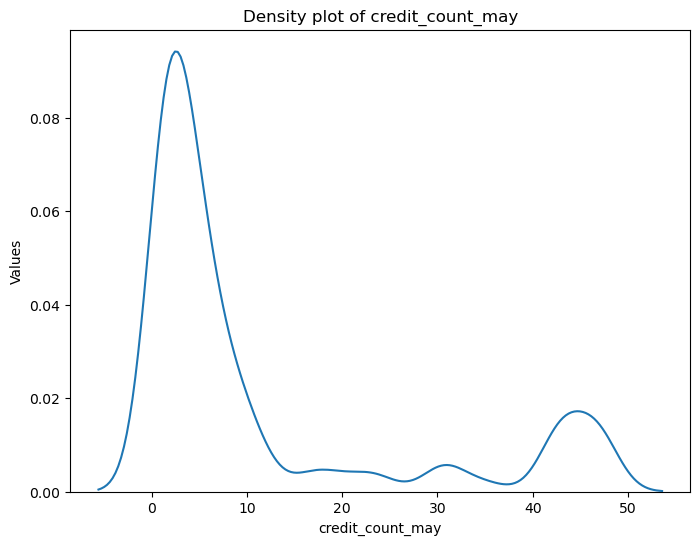

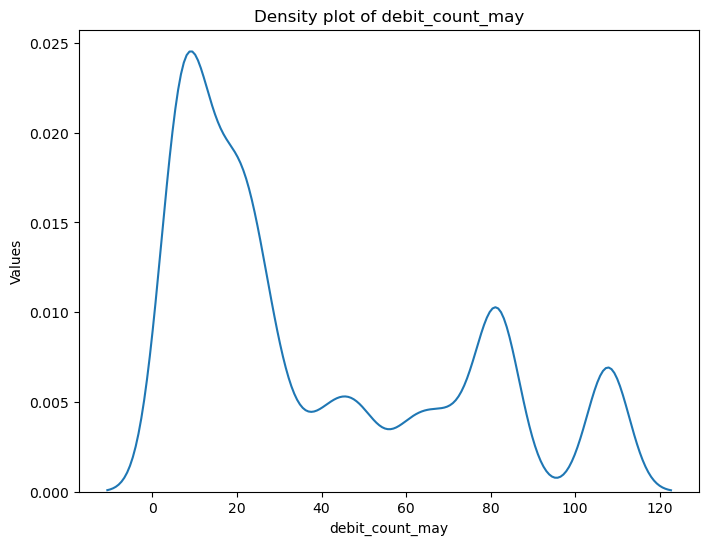

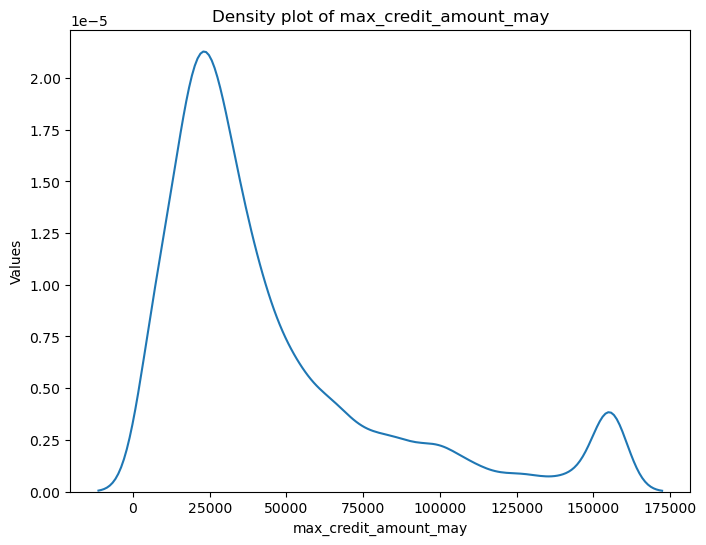

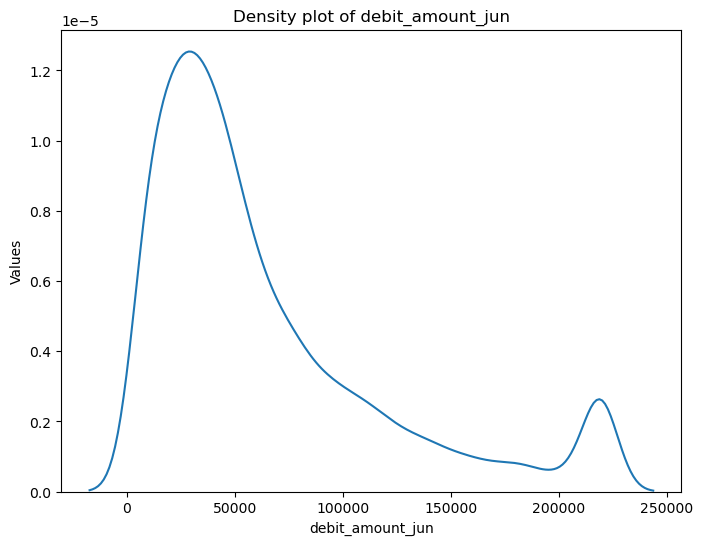

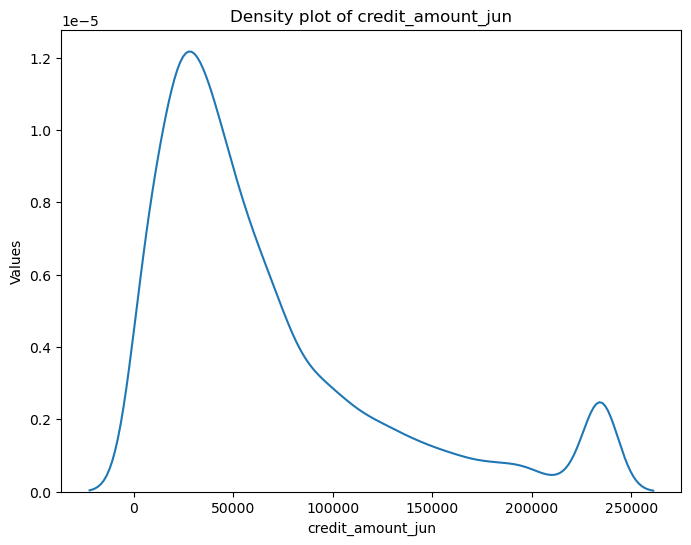

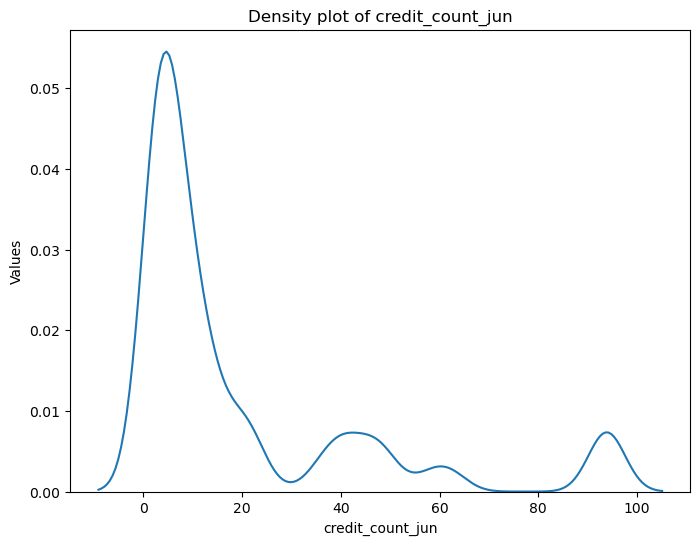

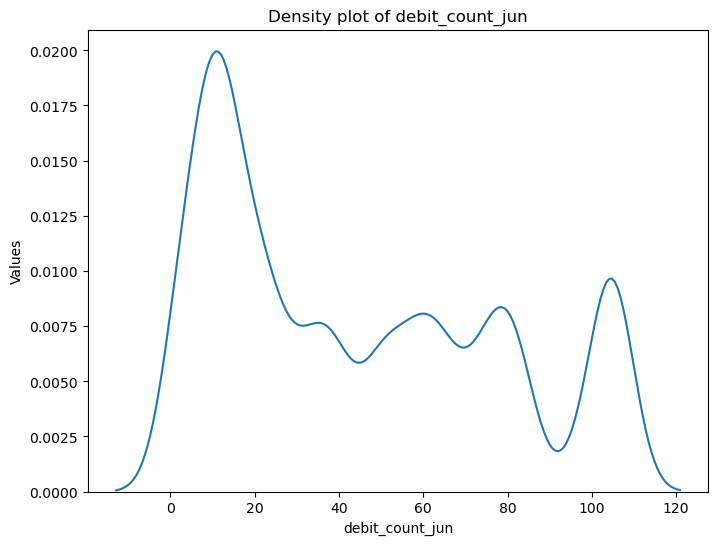

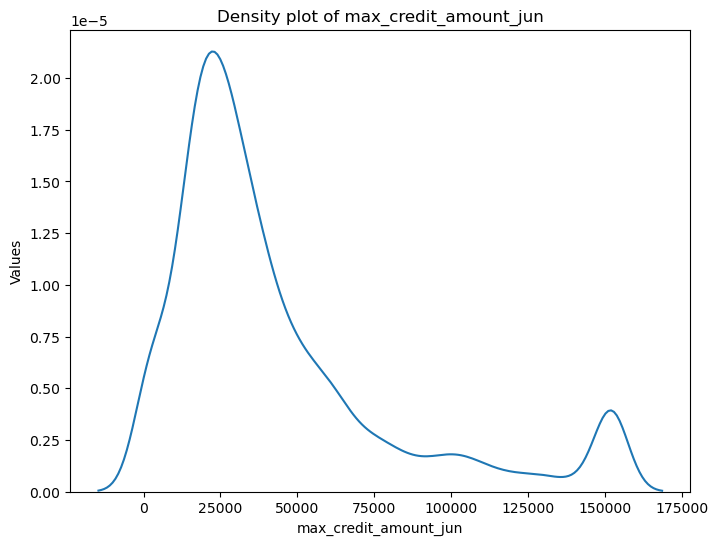

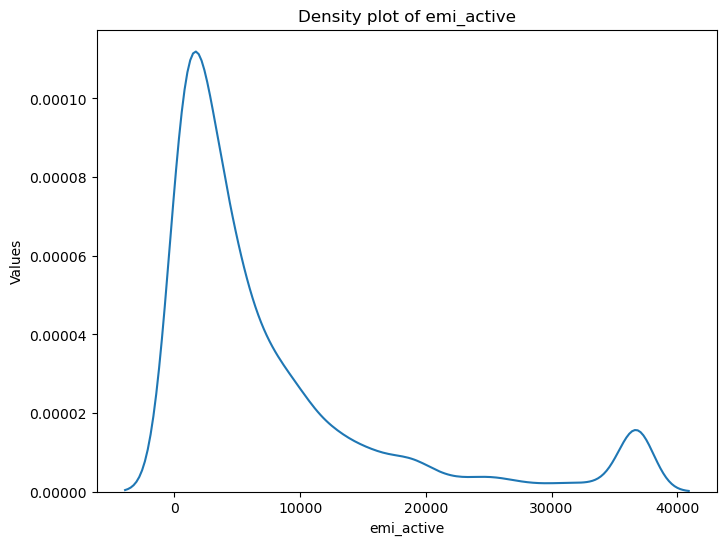

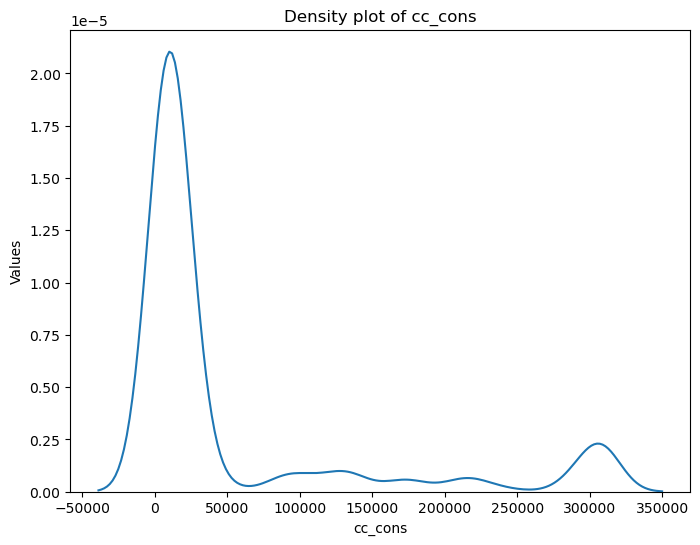

In [189]:
for col in seen_data_continuous.columns:
    plt.figure(figsize=(8, 6))
    sns.kdeplot(x=col, data=seen_data_continuous)
    plt.title(f'Density plot of {col}')
    plt.xlabel(col)
    plt.ylabel('Values')
    plt.show()

## Taking Log transformation of the dataset to reduce skewness

In [190]:
# Loop over each column in the dataset
for column in seen_data_continuous.columns:
    # Apply log transformation to numeric columns
    if np.issubdtype(seen_data_continuous[column].dtype, np.number):
        seen_data_continuous[column] = np.log(seen_data_continuous[column] + 1e-20)

In [191]:
seen_data_continuous.head()

Emp_Tenure_Years  Tenure_with_Bank  Avg_days_between_transaction  \
111          2.708050          0.000000                      2.833213   
112          2.708050          1.791759                      2.639057   
113          3.198673          0.000000                      1.098612   
114          1.504077          1.791759                      1.386294   
115          2.533697          1.386294                      1.945910   

     cc_cons_apr  dc_cons_apr  cc_cons_may  dc_cons_may  cc_cons_jun  \
111    10.122342     5.934894     9.238733    10.146910     9.698393   
112     9.849117     6.873164     9.936535     6.018520     8.346879   
113     8.644508     7.909857     7.582993     8.277186    10.083985   
114    10.325138     7.119636     9.442236     9.120212     9.771155   
115     8.914814     8.840152     8.381144     7.569928     7.659643   

     dc_cons_jun  cc_count_apr  ...  credit_count_may  debit_count_may  \
111     9.344172      0.693147  ...          0.693147         3.688879   
112     6.785588      0.000000  ...          0.693147         4.356709   
113     8.550241      3.761200  ...          0.693147         4.406719   
114     9.521517      3.970292  ...          3.135494         3.637586   
115     8.828960      4.204693  ...          3.178054         3.912023   

     max_credit_amount_may  debit_amount_jun  credit_amount_jun  \
111              10.108997         10.310662           9.454149   
112              10.083640         10.648255          11.241195   
113               9.282847         10.974613          11.229010   
114               9.442007         11.154127          11.137621   
115              10.135115          9.217415          11.291530   

     credit_count_jun  debit_count_jun  max_credit_amount_jun  emi_active  \
111          0.693147         4.174387              10.836360    7.423025   
112          3.044522         4.143135              10.053028    9.476033   
113          1.945910         0.693147              10.204925   10.141530   
114          3.044522         4.418841              10.669815    8.173104   
115          2.079442         3.465736              10.374865    9.455671   

       cc_cons  
111   9.904187  
112   9.227492  
113   9.686264  
114   8.949884  
115  11.476344  

[5 rows x 37 columns]

In [192]:
df_log = pd.concat([seen_data_continuous, cat_encoding], axis = 1)
df_log.head()

Emp_Tenure_Years  Tenure_with_Bank  Avg_days_between_transaction  \
111          2.708050          0.000000                      2.833213   
112          2.708050          1.791759                      2.639057   
113          3.198673          0.000000                      1.098612   
114          1.504077          1.791759                      1.386294   
115          2.533697          1.386294                      1.945910   

     cc_cons_apr  dc_cons_apr  cc_cons_may  dc_cons_may  cc_cons_jun  \
111    10.122342     5.934894     9.238733    10.146910     9.698393   
112     9.849117     6.873164     9.936535     6.018520     8.346879   
113     8.644508     7.909857     7.582993     8.277186    10.083985   
114    10.325138     7.119636     9.442236     9.120212     9.771155   
115     8.914814     8.840152     8.381144     7.569928     7.659643   

     dc_cons_jun  cc_count_apr  ...  credit_count_jun  debit_count_jun  \
111     9.344172      0.693147  ...          0.693147         4.174387   
112     6.785588      0.000000  ...          3.044522         4.143135   
113     8.550241      3.761200  ...          1.945910         0.693147   
114     9.521517      3.970292  ...          3.044522         4.418841   
115     8.828960      4.204693  ...          2.079442         3.465736   

     max_credit_amount_jun  emi_active    cc_cons  account_type_saving  \
111              10.836360    7.423025   9.904187                    0   
112              10.053028    9.476033   9.227492                    0   
113              10.204925   10.141530   9.686264                    0   
114              10.669815    8.173104   8.949884                    0   
115              10.374865    9.455671  11.476344                    0   

     gender_M  Income_LOW  Income_MEDIUM  NetBanking_Flag  
111         1           0              1                0  
112         1           0              0                0  
113         1           0              1                1  
114         0           0              1                1  
115         1           0              1                1  

[5 rows x 42 columns]

In [201]:
df_log.isna().sum()

Emp_Tenure_Years                   0
Tenure_with_Bank                   0
Avg_days_between_transaction       0
cc_cons_apr                        0
dc_cons_apr                        0
cc_cons_may                        0
dc_cons_may                        0
cc_cons_jun                        0
dc_cons_jun                        0
cc_count_apr                       0
cc_count_may                       0
cc_count_jun                       0
dc_count_apr                       0
dc_count_may                       0
dc_count_jun                       0
card_lim                           0
investment_1                       0
investment_2                       0
investment_3                       0
investment_4                    3225
debit_amount_apr                   0
credit_amount_apr                  0
debit_count_apr                    0
credit_count_apr                   0
max_credit_amount_apr              0
debit_amount_may                   0
credit_amount_may                  0
c

In [202]:
df_log.drop(columns = 'investment_4', inplace = True)

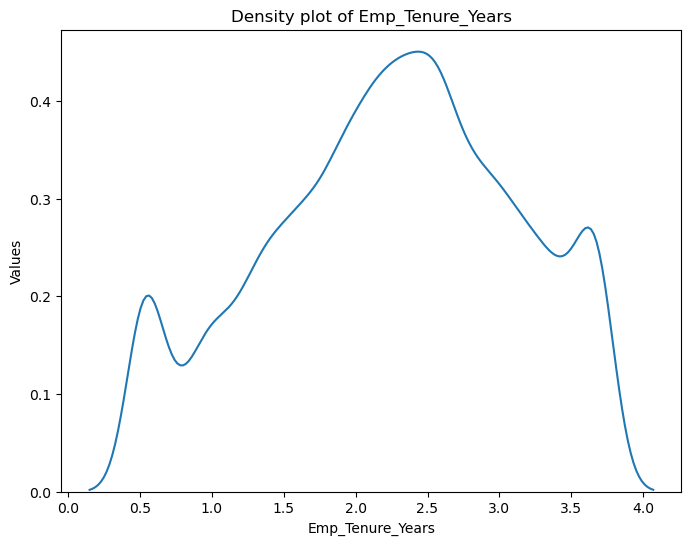

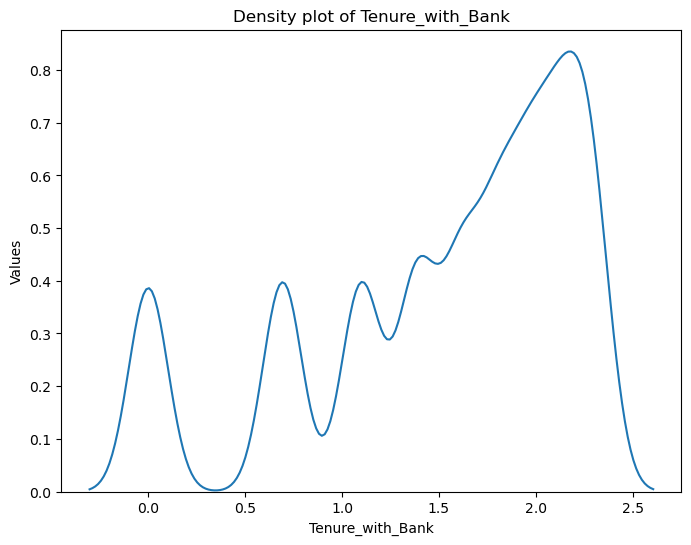

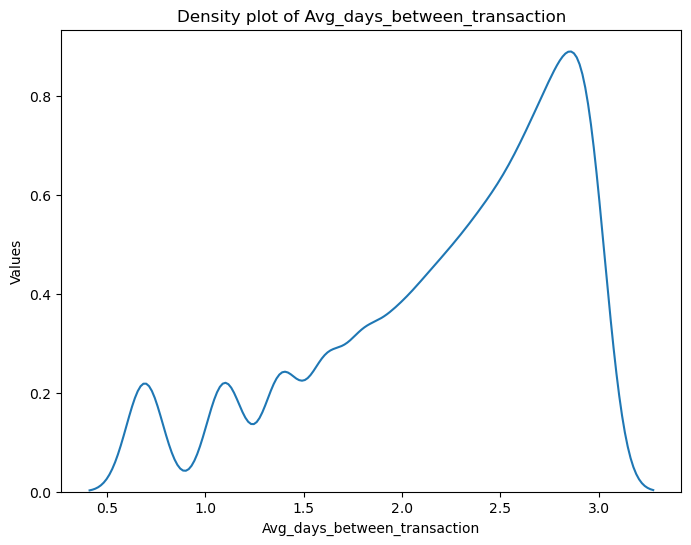

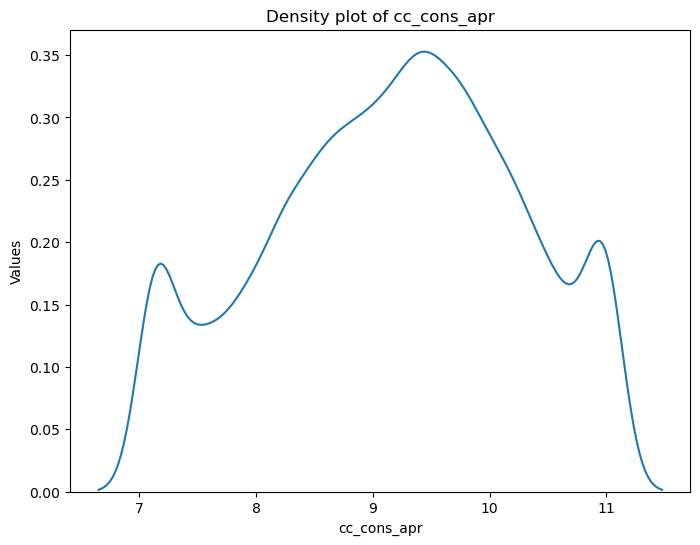

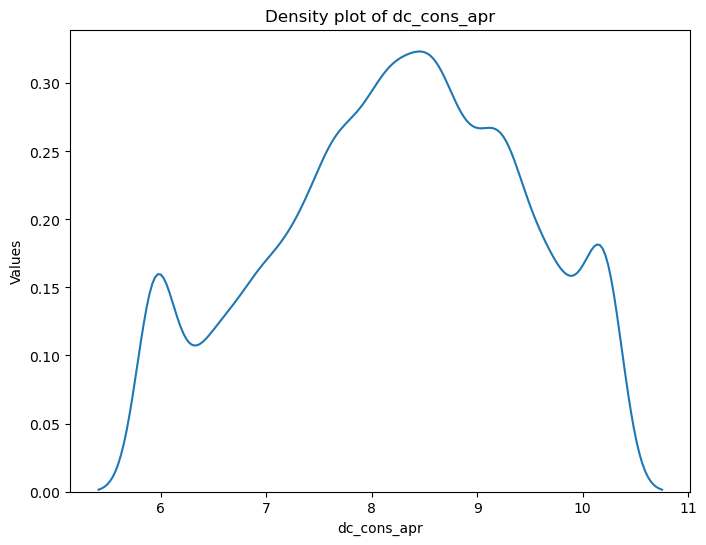

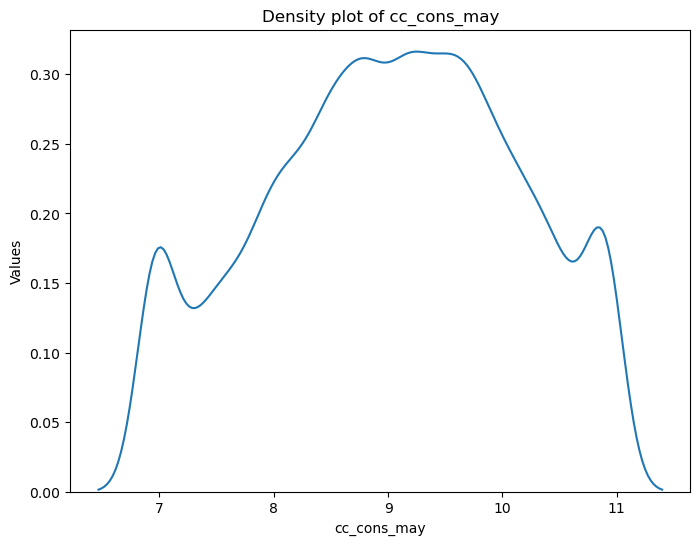

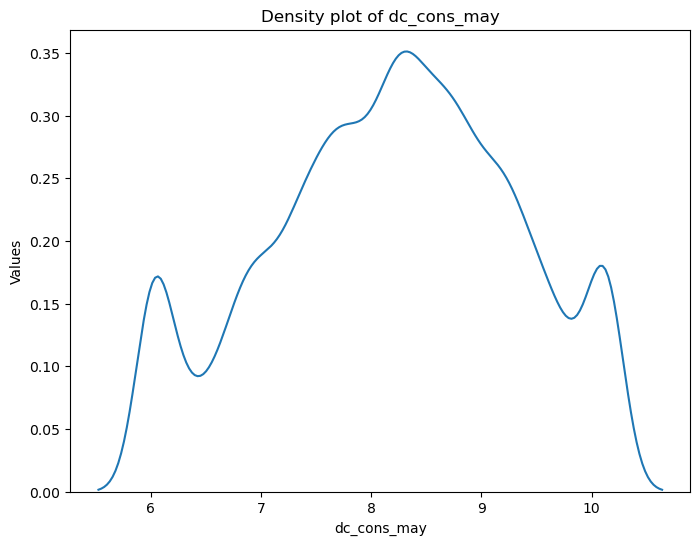

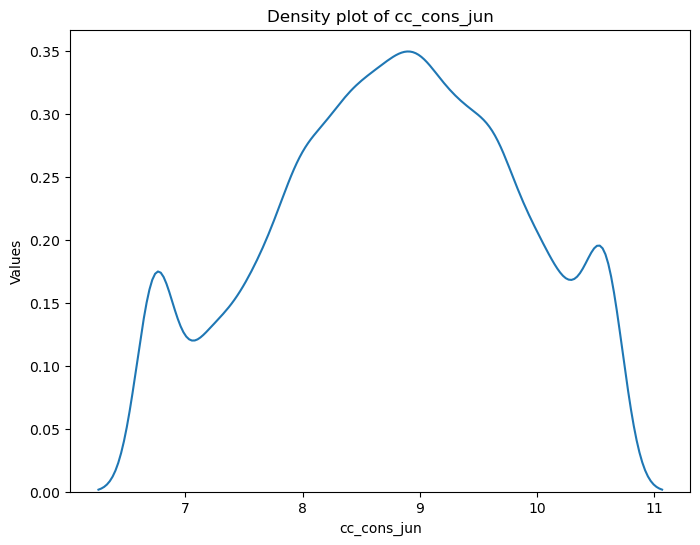

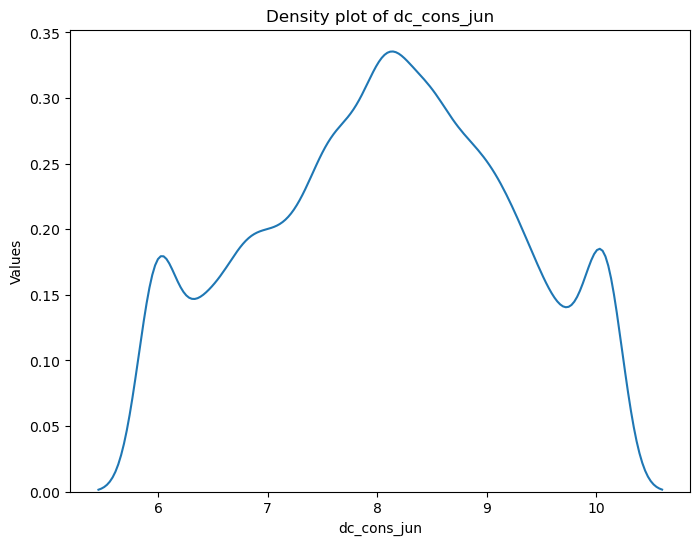

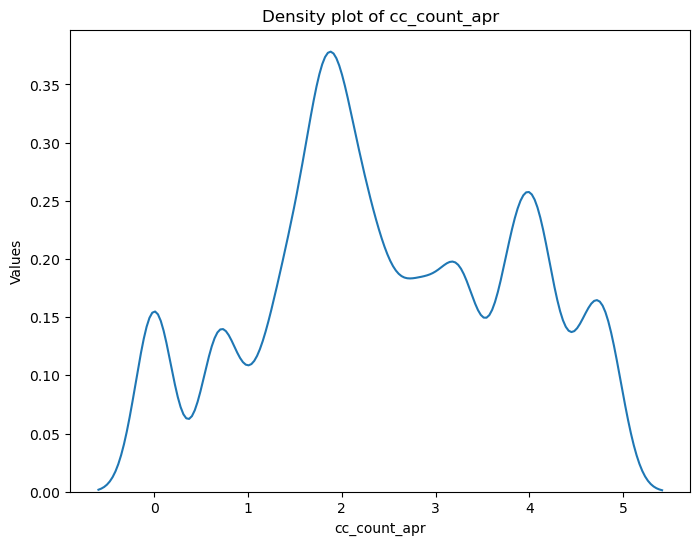

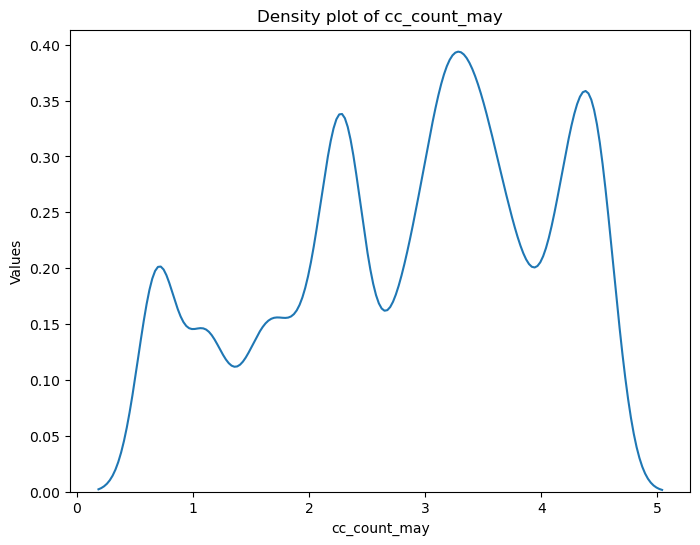

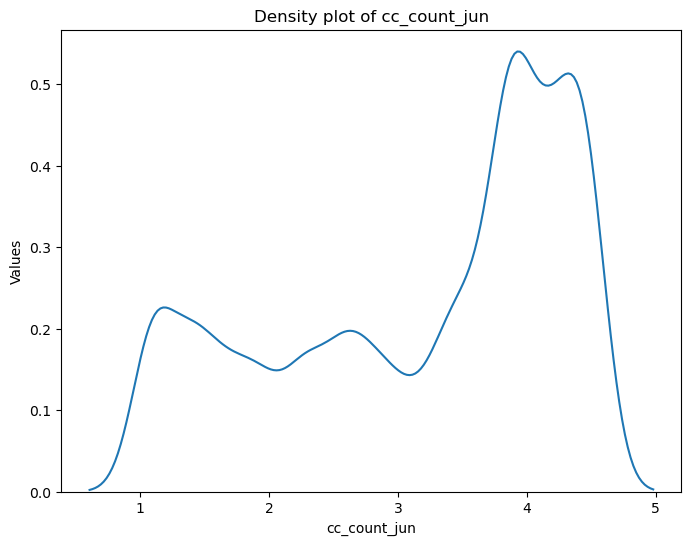

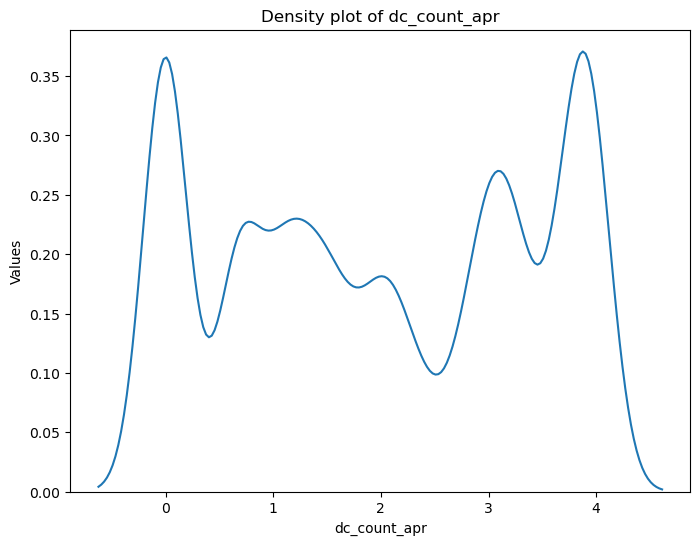

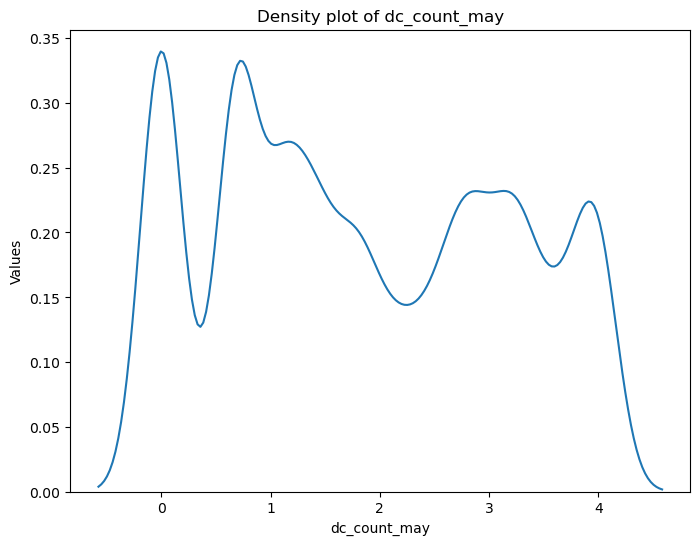

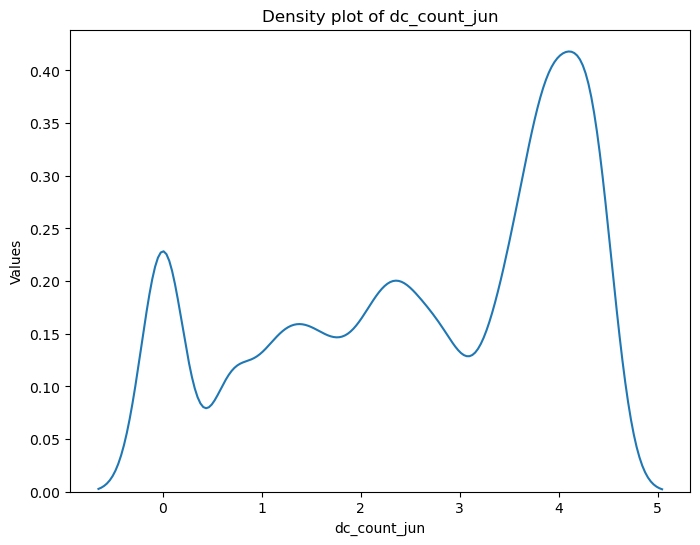

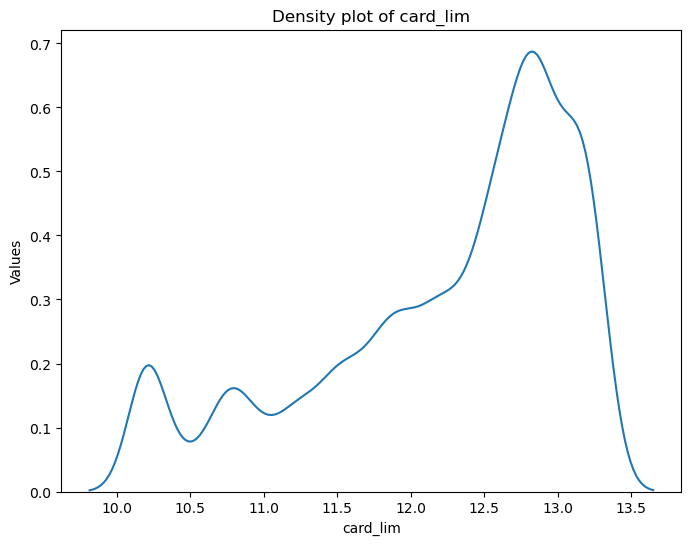

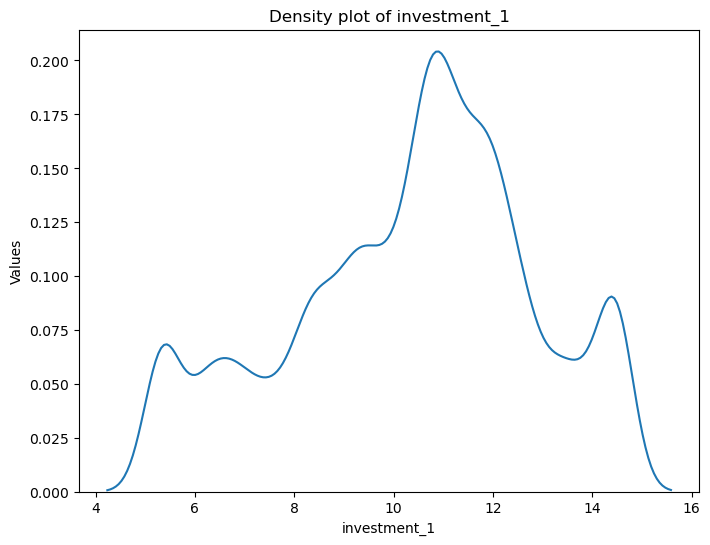

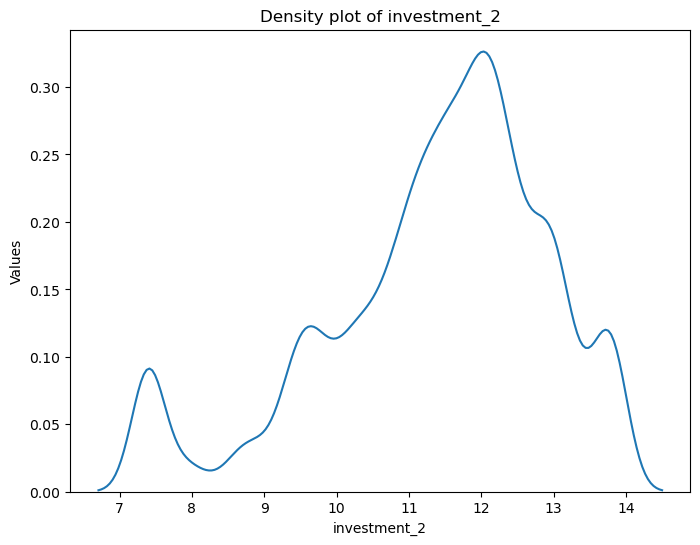

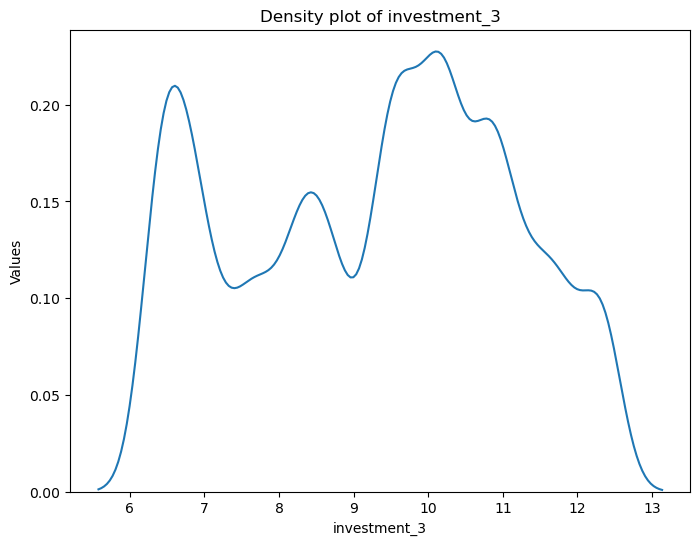

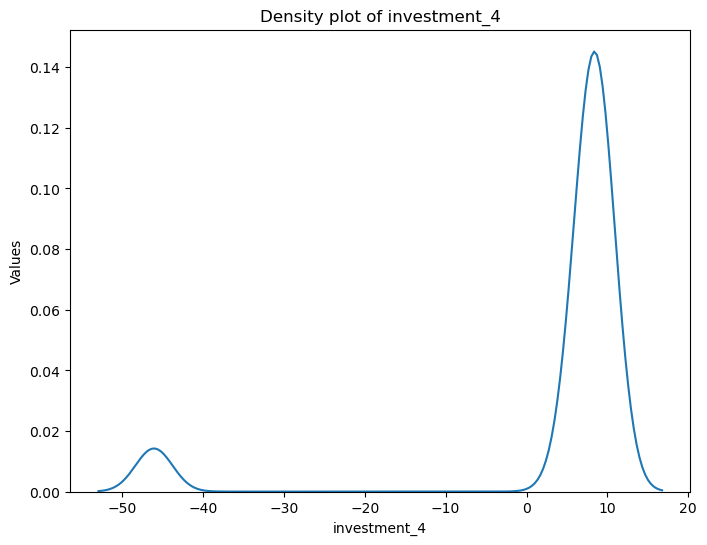

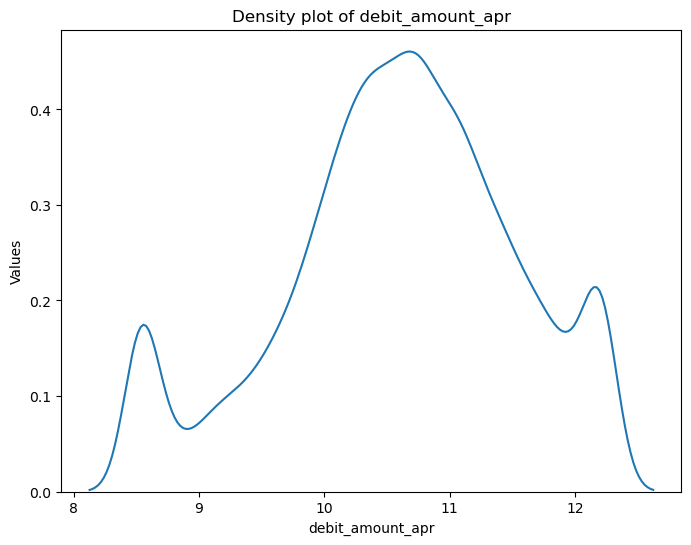

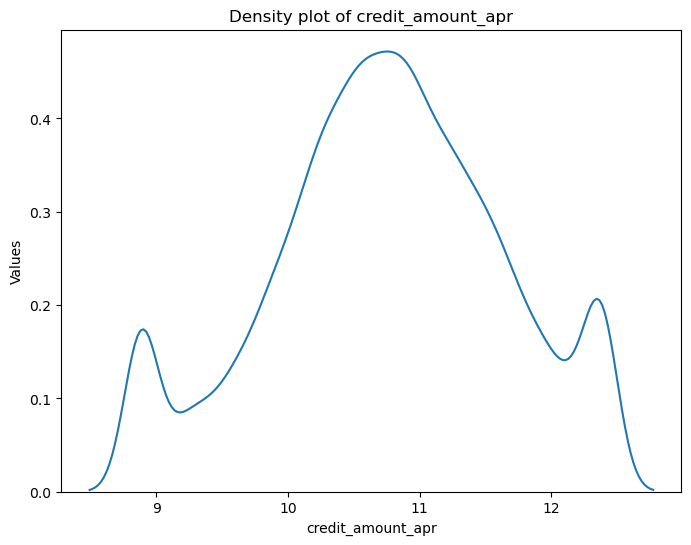

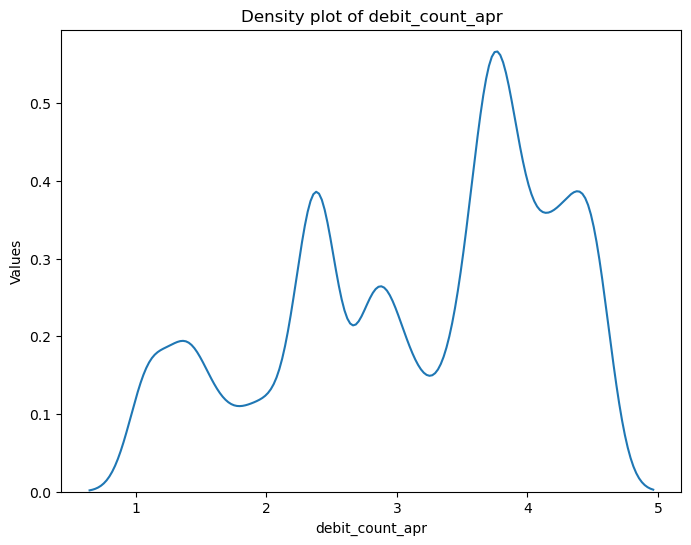

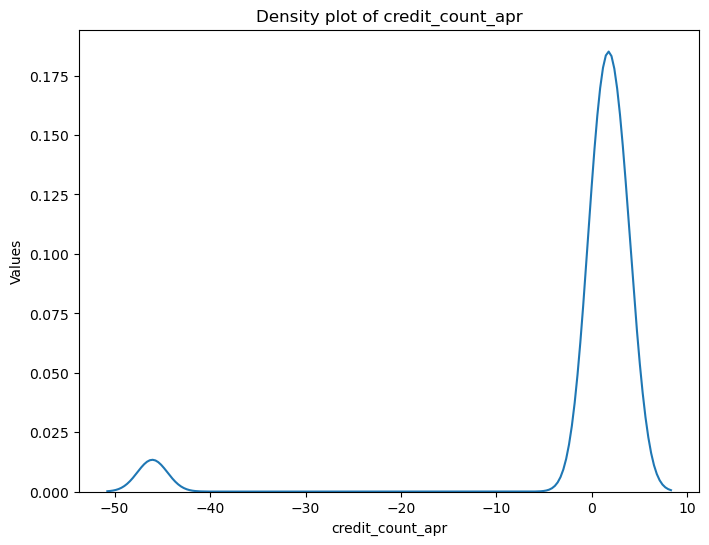

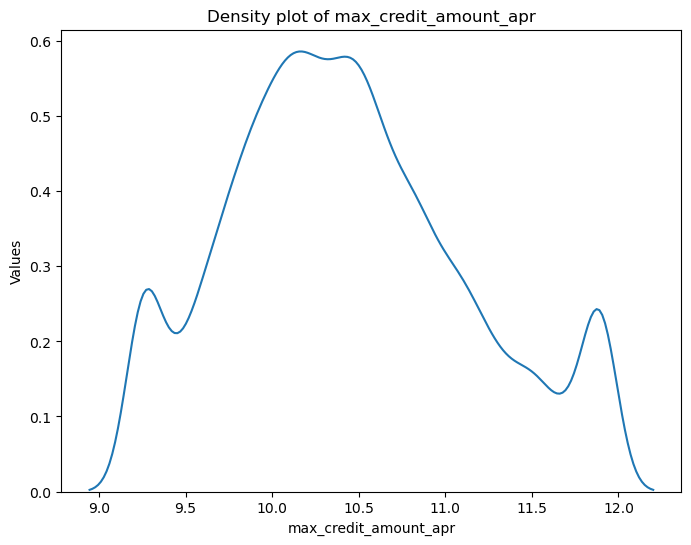

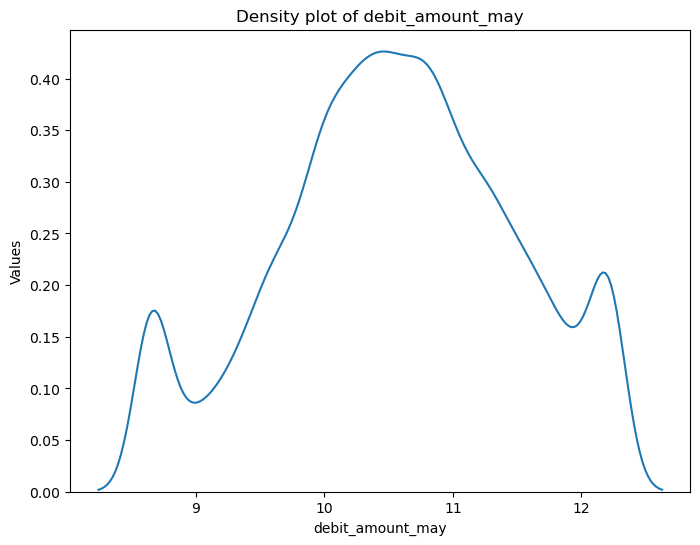

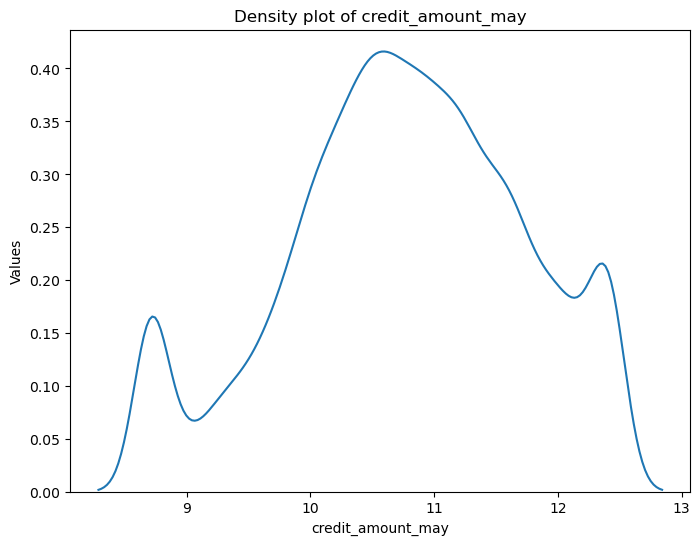

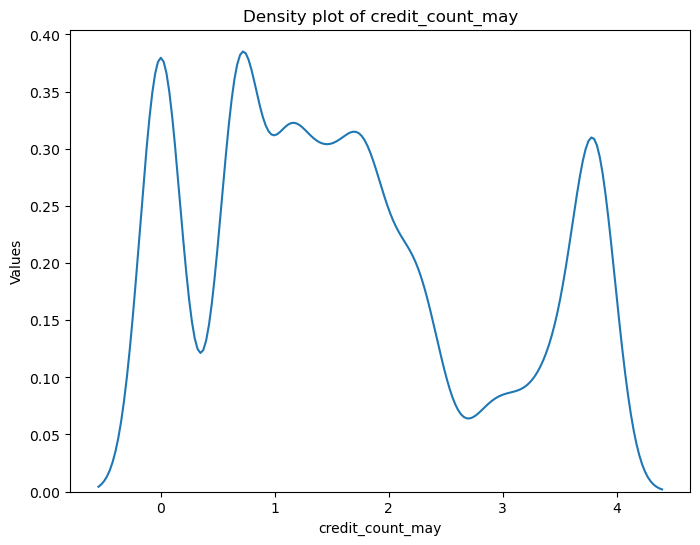

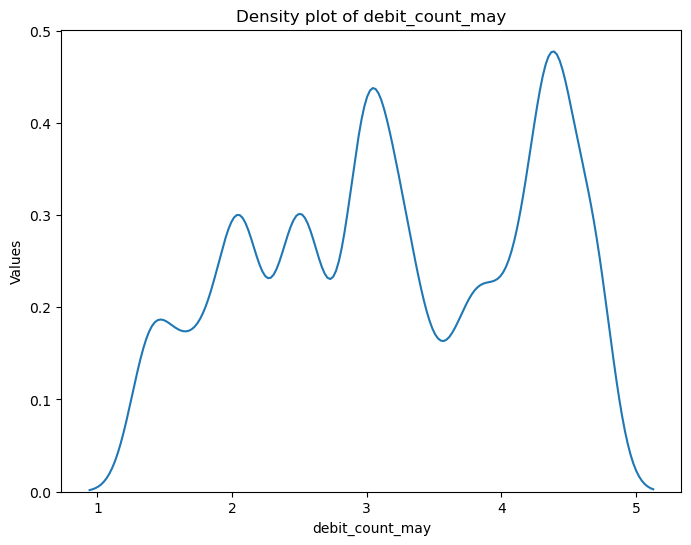

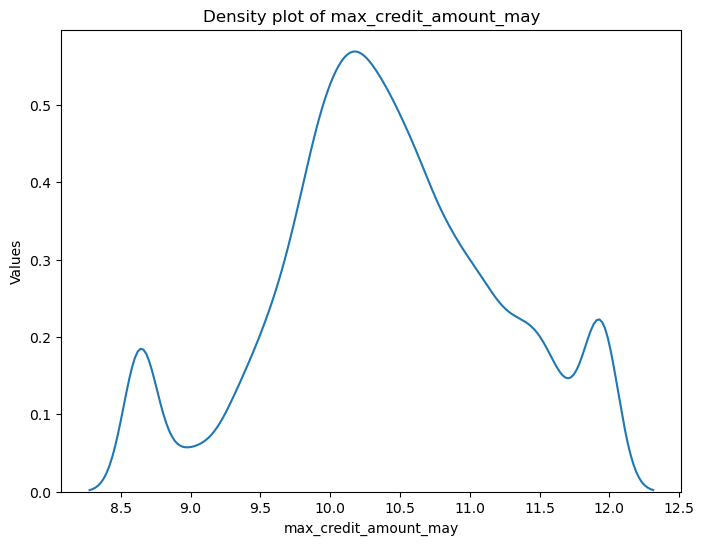

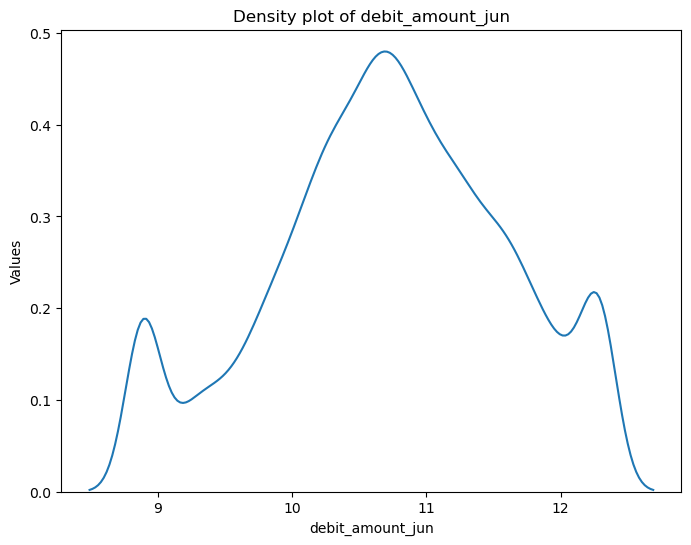

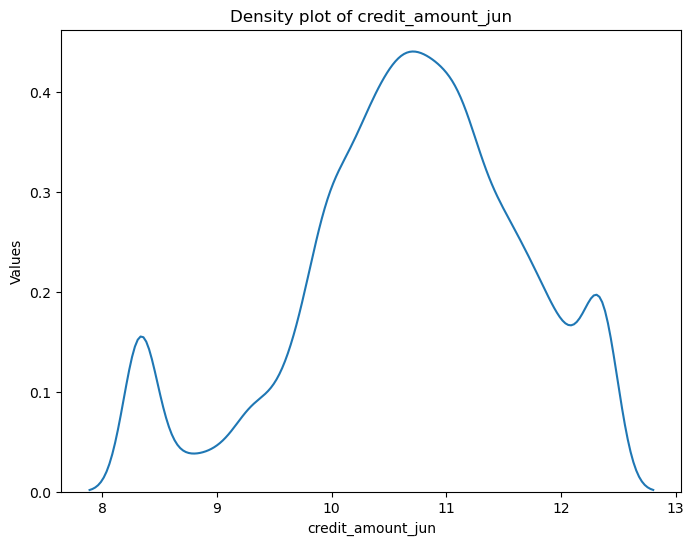

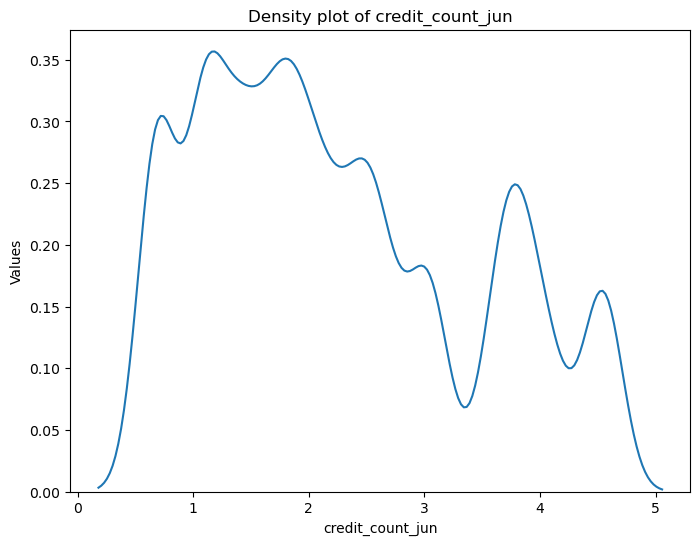

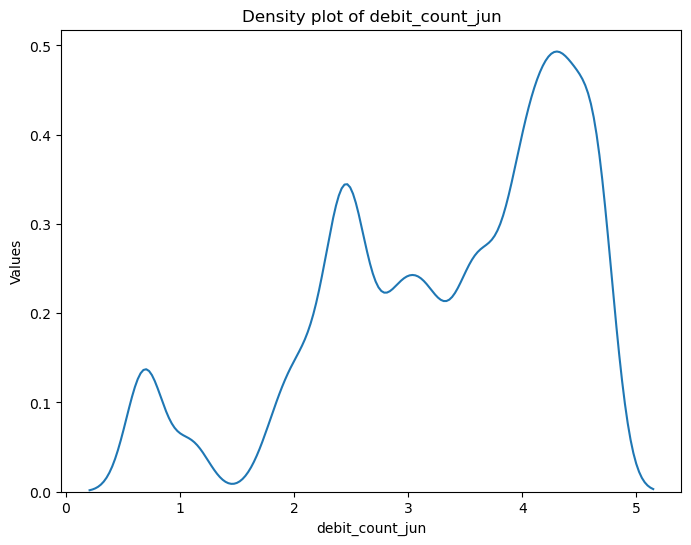

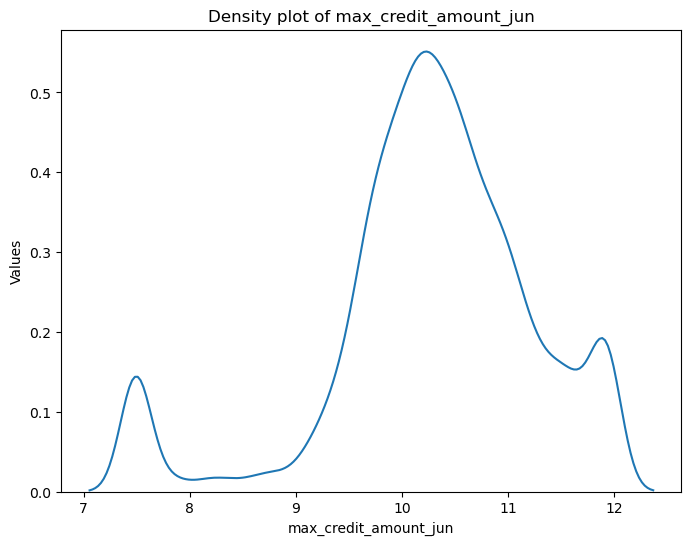

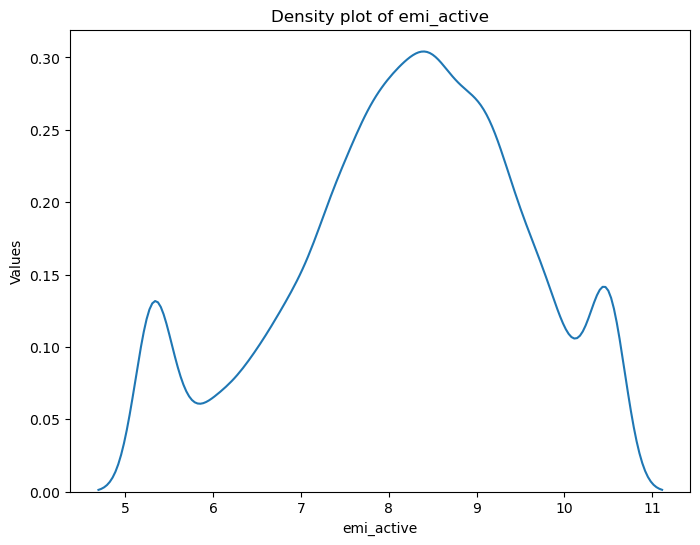

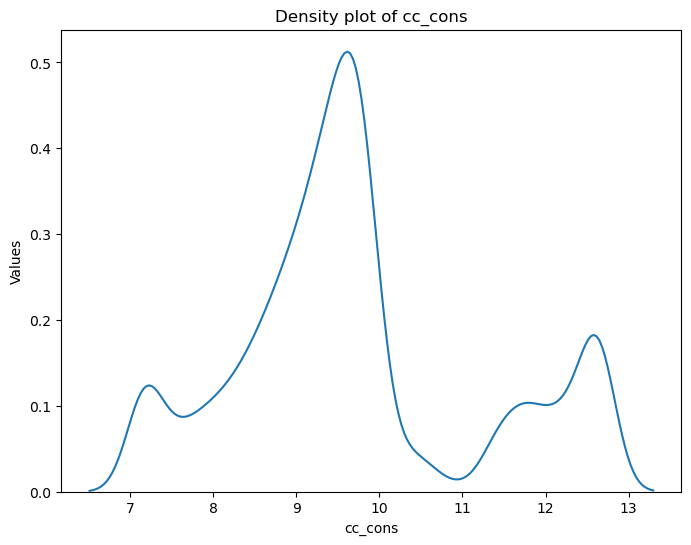

In [203]:
for col in seen_data_continuous.columns:
    plt.figure(figsize=(8, 6))
    sns.kdeplot(x=col, data=seen_data_continuous)
    plt.title(f'Density plot of {col}')
    plt.xlabel(col)
    plt.ylabel('Values')
    plt.show()

In [204]:
y = df_log.cc_cons
X = df_log[df_log.columns.difference(['cc_cons'])]

In [205]:
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X, y, test_size=0.2, random_state=42)

In [206]:
X_train_log.head()

Avg_days_between_transaction  Emp_Tenure_Years  Income_LOW  \
9950                       2.995732          0.530628           0   
9791                       1.098612          2.580217           0   
7204                       2.079442          1.386294           0   
11404                      2.944439          2.128232           0   
931                        2.302585          2.862201           0   

       Income_MEDIUM  NetBanking_Flag  Tenure_with_Bank  account_type_saving  \
9950               1                0          1.945910                    0   
9791               1                1          2.302585                    0   
7204               1                1          2.302585                    1   
11404              1                1          1.609438                    0   
931                1                1          2.302585                    1   

        card_lim  cc_cons_apr  cc_cons_jun  ...  debit_count_jun  \
9950   12.842649     7.660962     9.624962  ...         4.174387   
9791   10.203592     8.957979     9.454293  ...         1.945910   
7204   10.691945     9.077020     9.638205  ...         3.912023   
11404  12.751300     9.867953     9.895607  ...         2.890372   
931    10.203592     8.985012     9.191361  ...         4.663439   

       debit_count_may  emi_active  gender_M  investment_1  investment_2  \
9950          4.406719    7.925981         1     10.592926     13.060488   
9791          2.995732    8.043098         1     12.021739     12.183350   
7204          4.406719    8.616622         1     10.427753     11.686677   
11404         2.079442    7.716158         1      8.716044      9.814656   
931           2.639057    8.970063         1      6.265776     12.789630   

       investment_3  max_credit_amount_apr  max_credit_amount_jun  \
9950      11.413381              10.568750              10.563853   
9791      11.127263              10.183578              10.533935   
7204       8.294050              10.267679              11.076372   
11404     11.775290              10.566742               9.532424   
931        6.368187              10.645592               7.489412   

       max_credit_amount_may  
9950               11.095074  
9791                9.766808  
7204               10.300584  
11404              10.104222  
931                11.954419  

[5 rows x 40 columns]

In [207]:
X_test_log.head()

Avg_days_between_transaction  Emp_Tenure_Years  Income_LOW  \
11610                      2.197225          1.568616           0   
6586                       1.945910          3.688879           0   
13278                      2.302585          3.178054           0   
973                        2.772589          2.901422           1   
6081                       2.197225          1.686399           1   

       Income_MEDIUM  NetBanking_Flag  Tenure_with_Bank  account_type_saving  \
11610              1                1          1.945910                    0   
6586               1                1          2.079442                    0   
13278              1                0          2.079442                    0   
973                0                1          0.693147                    0   
6081               0                1          1.945910                    0   

        card_lim  cc_cons_apr  cc_cons_jun  ...  debit_count_jun  \
11610  13.214031    10.022993     8.070594  ...         2.484907   
6586   10.203592     7.312887     8.899482  ...         3.951244   
13278  13.041153     9.515764     8.385261  ...         3.663562   
973    10.691945     9.335964     8.291547  ...         4.060443   
6081   13.262125     8.863899     7.869402  ...         3.891820   

       debit_count_may  emi_active  gender_M  investment_1  investment_2  \
11610         4.682131    7.890122         1     12.019186     10.673596   
6586          2.833213    7.755797         1     10.863020     10.820477   
13278         2.079442    7.092183         1      7.608275     12.013701   
973           2.484907    9.427683         1     10.764255     11.762241   
6081          3.332205    5.293207         1      6.692394     12.969849   

       investment_3  max_credit_amount_apr  max_credit_amount_jun  \
11610      9.537700              10.051606               9.503085   
6586       7.034388              10.732912              11.573861   
13278     11.512925              10.396383              10.261791   
973       11.477899              10.815831              10.136383   
6081       6.368187              11.896754              10.487712   

       max_credit_amount_may  
11610              10.430374  
6586                9.343297  
13278               8.635865  
973                10.640652  
6081               11.281006  

[5 rows x 40 columns]

In [208]:
y_train_log.head()

9950     9.245708
9791     9.767725
7204     9.788582
11404    8.686936
931      9.434923
Name: cc_cons, dtype: float64

In [209]:
y_test_log.head()

11610     9.357294
6586      9.806261
13278     9.327768
973       9.716375
6081     10.371959
Name: cc_cons, dtype: float64

In [210]:
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train_log, y_train_log)

# Predict on the test data
y_pred = model.predict(X_test_log)

In [211]:
print(metrics.mean_absolute_percentage_error(y_train_log, model.predict(X_train_log)))

0.114665246270469


In [212]:
print(metrics.mean_absolute_percentage_error(y_test_log, y_pred))

0.11623307789461021


In [213]:
knn_model_log = KNeighborsRegressor(n_neighbors=19, weights='uniform')

In [214]:
knn_model_log = knn_model_log.fit(X_train_log, y_train_log)

In [223]:
train_predictions = knn_model_log.predict(X_train_log)
actual_train_predictions = np.exp(train_predictions)

In [224]:
actual_train_predictions

array([19899.22597848, 22185.28510472, 12589.39982061, ...,
       11382.64913069, 12309.61089153, 21144.50042123])

In [218]:
error = rmspe(pred, y_test_log)

In [219]:
print("The RMSPE value is:", error, "%")

The RMSPE value is: 99.9779498144 %


In [221]:
from sklearn.metrics import r2_score
r2 = r2_score(y_train, knn_model_log.predict(X_train_log))

print("R-squared (R2) value:", r2)

R-squared (R2) value: -0.33918052883364447


In [222]:
r2 = r2_score(y_test, knn_model_log.predict(X_test_log))

print("R-squared (R2) value:", r2)

R-squared (R2) value: -0.3311006287784961


## Linear Regression

In [228]:
# Fitting Model

lin_reg=lin_reg.fit(X_train_log, y_train_log)

y_pred=lin_reg.predict(X_test_log)
print(metrics.r2_score(y_train_log,lin_reg.predict(X_train_log)))

print(metrics.mean_absolute_error(y_train_log,lin_reg.predict(X_train_log)))
print(metrics.mean_absolute_error(y_test_log,y_pred))

0.0030335619773859124
1.1079626225078762
1.1192982137073901


### Using Ridge 

In [235]:
from sklearn import linear_model

In [236]:
# Initializing Model

tuned_parameters = [{'alpha': [0.001,0.01,0.1,1.,10.,100.]}]

RidgeCV = GridSearchCV(linear_model.Ridge(),
                   tuned_parameters,
                   cv=5,
                   n_jobs=-1,
                   scoring='neg_mean_squared_error')

RidgeCV.fit(X_train_log,y_train_log)

print('Best combination:', RidgeCV.best_params_);

Best combination: {'alpha': 100.0}


In [237]:
# Fitting Model

Ridge=linear_model.Ridge(alpha=100)

Ridge_model=Ridge.fit(X_train_log, y_train_log)

y_pred=Ridge_model.predict(X_test_log)

print(metrics.r2_score(y_train_log,lin_reg.predict(X_train_log)))
print(metrics.mean_absolute_error(y_train,lin_reg.predict(X_train_log)))
print(metrics.mean_absolute_error(y_test_log,y_pred))

0.0030335619773859124
53152.734979713
1.1191028406845236


### Using Lasso 

In [239]:
# Initializing Model

tuned_parameters = [{'alpha': [0.0,0.0001,0.001,0.01,0.1,1,10,100]}]

LassoCV = GridSearchCV(linear_model.Lasso(),
                   tuned_parameters,
                   cv=10,
                   n_jobs=-1,
                   scoring='neg_mean_squared_error')

LassoCV.fit(X_train_log,y_train_log)

print('Best combination:', LassoCV.best_params_);

Best combination: {'alpha': 1}


In [240]:
# Fitting Model
Lasso = linear_model.Lasso(alpha=1)
Lasso.fit(X_train_log,y_train_log)

print(metrics.r2_score(y_train,lin_reg.predict(X_train_log)))
print(metrics.mean_absolute_error(y_train_log,lin_reg.predict(X_train_log)))
print(metrics.mean_absolute_error(y_test_log,y_pred))

-0.3391816535534571
1.1079626225078762
1.1191028406845236


### Using Elastic Net 

In [242]:
# Initializing Model

tuned_parameters = [{'alpha': [0.0001,0.001,0.01,0.1,1.,10.,100.]}]

ElasticNet_CV = GridSearchCV(linear_model.ElasticNet(),
                   tuned_parameters,
                   cv=10,
                   n_jobs=-1,
                   scoring='neg_mean_squared_error')

ElasticNet_CV.fit(X_train_log,y_train_log)

print('Best combination:', ElasticNet_CV.best_params_);

Best combination: {'alpha': 1.0}


In [243]:
# Fitting Model
EN = linear_model.ElasticNet(alpha=1)
EN_model=EN.fit(X_train_log,y_train_log)


y_pred=EN_model.predict(X_test_log)

print(metrics.r2_score(y_train_log,lin_reg.predict(X_train_log)))
print(metrics.mean_absolute_error(y_train_log,lin_reg.predict(X_train_log)))
print(metrics.mean_absolute_error(y_test_log,y_pred))

0.0030335619773859124
1.1079626225078762
1.116313789808266


## Analysis of RMSPE with every model

In [245]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor,AdaBoostRegressor
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.svm import SVR, LinearSVR
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

In [247]:
models=[RandomForestRegressor(),AdaBoostRegressor(),BaggingRegressor(),SVR(),KNeighborsRegressor(),
       ElasticNet(),GradientBoostingRegressor(),DecisionTreeRegressor(), Lasso(),LinearRegression(),Ridge()]

model_names=['RandomForestRegressor','AdaBoostRegressor','BaggingRegressor','SVR','KNeighborsRegressor','ElasticNet'
            'GradientBoostingRegressor','DecisionTreeRegressor',' Lasso','LinearRegression',
            'Ridge']
RMSPE=[]
d={}
for model in range (len(models)):
    clf = models[model]
    clf.fit(X_train_log,y_train_log)
    test_pred=clf.predict(X_test_log)
    RMSPE.append(np.sqrt(np.mean(np.square((test_pred) - (y_test_log)))))
d={'Modelling Algo':model_names,'RMSPE':RMSPE} 

In [248]:
rmspe_frame=pd.DataFrame.from_dict(d, orient='index').transpose()
rmspe_frame

Modelling Algo     RMSPE
0                 RandomForestRegressor  1.509936
1                     AdaBoostRegressor  1.500679
2                      BaggingRegressor  1.583037
3                                   SVR  1.506512
4                   KNeighborsRegressor  1.642431
5   ElasticNetGradientBoostingRegressor  1.494955
6                 DecisionTreeRegressor  1.497567
7                                 Lasso  2.170173
8                      LinearRegression  1.494955
9                                 Ridge   1.49695
10                                  NaN  1.496948

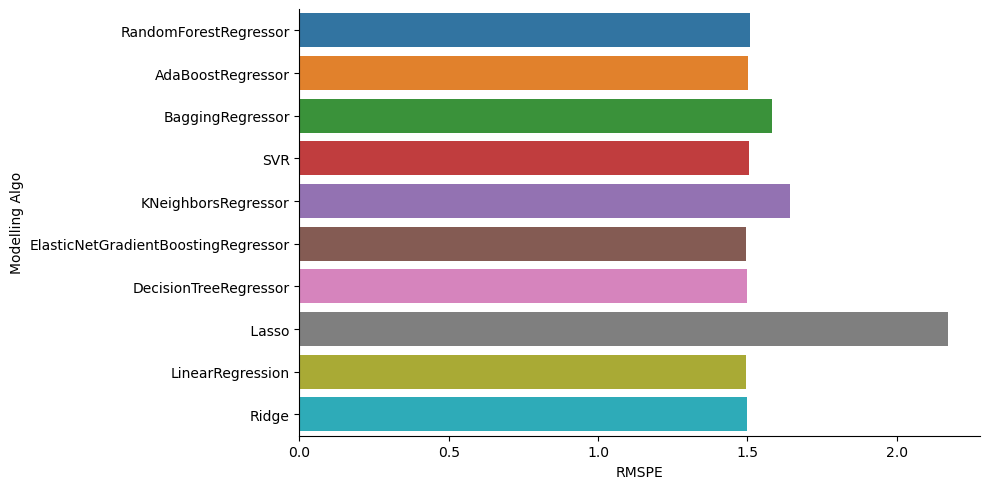

In [249]:
sns.factorplot(y='Modelling Algo',x='RMSPE',data = rmspe_frame, kind='bar',size=5, aspect=2)

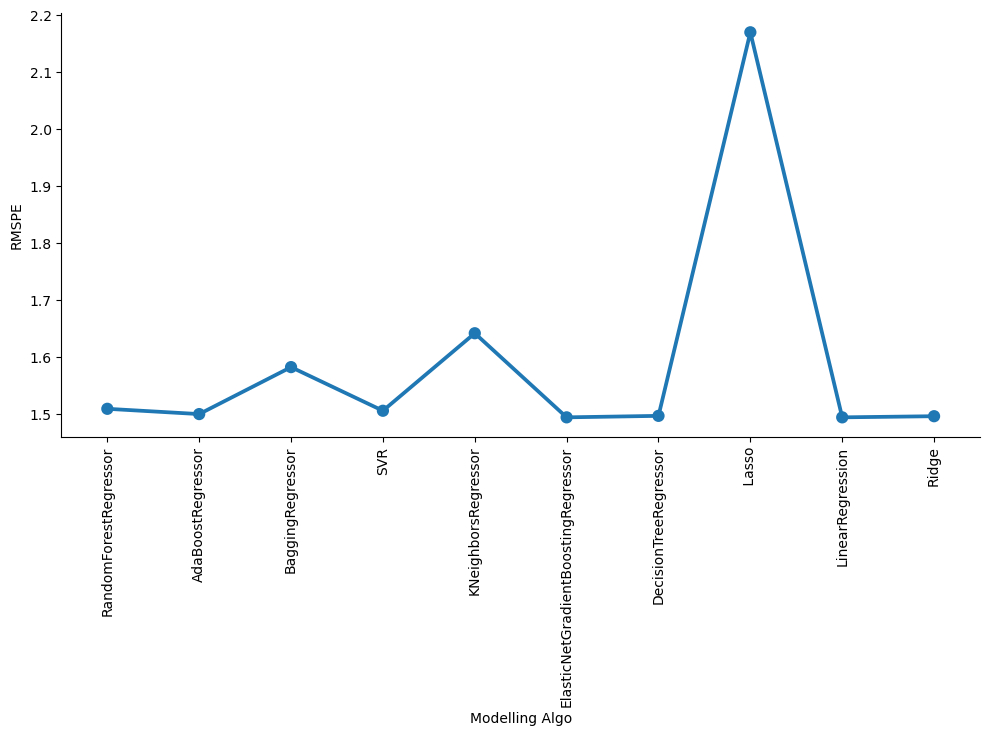

In [250]:
g = sns.factorplot(x='Modelling Algo',y='RMSPE',data=rmspe_frame,kind='point',size=5,aspect=2)
g.set_xticklabels(rotation=90)
plt.show()

## from the above graph we can conclude that LinearRegression and Ridge are giving the least RMSPE values

## XXX  END  XXX